# Stock Market Prediction: Modeling

In this series of notebooks, I will create a machine learning algorithm to predict the stock price (Adjusted Close) and make a trading recommendation for the user. 

The input features are:
- Open 
- Close
- Low
- High

For the following stocks, I will create a trained algorithm:
- *Blue chip stocks*: Blue chip stocks are shares of large, established companies with stable financial performance and low risk.
    - BMW (BMW.DE)
    <p>&nbsp;</p> 
- *Growth stocks*: growth stocks are stocks of companies with high potential for future growth. These stocks often carry higher risks, but also offer higher potential returns
    - Tesla, Inc. (TSLA)
    - Bitcoin (BTC-USD)
    <p>&nbsp;</p>
- *Dividend stocks*: dividend stocks are stocks of companies that pay regular dividends to their shareholders. These stocks often carry lower risks and offer a regular source of income. 
    - Johnson & Johnson (JNJ)
    <p>&nbsp;</p>
- *Small-cap stocks*: small-cap stocks are stocks of small companies with higher risk and higher potential for growth and return.
     - Etsy, Inc (ETSY)

The following algorithm will be used for prediction:
- LSTM (Long Short-Term Memory)

This is a popular algorithms for stock prediction. 

The goal is to create an algorithm which can predict the stock prices with a tolerance of ± 5%.
Also, I want to show how the different stock categories influence the accuracy of the algorithm. 

The final program on Github.com (https://github.com/maximkiesel1/Stock_Market_Prediction)  can be used for all stocks.

In this notebook, the focus will be to do feature engineering, splitting the data, train the models and validate the performance. 

**Risk Disclaimer**:

Trading in the financial markets involves a high degree of risk and may not be suitable for all investors. The trading machine learning algorithm presented herein is an experimental program and is provided on an "as is" basis without any warranties, expressed or implied. The creators and owners of the algorithm do not make any representations or warranties, either express or implied, as to the accuracy, reliability, completeness, or appropriateness for any particular purpose of the information, analyses, algorithms, or models contained in this algorithm.

The creators and owners of the algorithm do not accept any liability for any loss or damage, including without limitation any loss of profit, which may arise directly or indirectly from use of or reliance on such information.

Trading and investment decisions are the sole responsibility of the user. It is the responsibility of the user to perform proper due diligence before making any investment or trading decisions. Users should seek professional advice before trading in the financial markets.

Past performance of the algorithm is not indicative of future results. The user assumes full responsibility and risk of using this algorithm. By using this algorithm, the user agrees to these terms and conditions and accepts full responsibility for all trading and investment decisions made using this algorithm.

## Table Of Contents 

#### 1. [Feature Engineering](#fe)  
#### 2. [Training/Validation With LSTM](#tlstm)
#### 3. [Comparison Stock Types](#comparison)
#### 4. [Prediction With LSTM](#plstm)

In [1]:
# load libraries
import sys

from sqlalchemy import create_engine, text, inspect
import ssl

import pandas as pd
import numpy as np

import ta

from sklearn.metrics import r2_score
from sklearn.model_selection import TimeSeriesSplit

import matplotlib.pyplot as plt

from sklearn.model_selection import RandomizedSearchCV

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import *
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.losses import MeanSquaredError
from tensorflow.keras.metrics import RootMeanSquaredError
from tensorflow.keras.optimizers.legacy import Adam
from tensorflow.keras.models import load_model
from keras.wrappers.scikit_learn import KerasRegressor
import tensorflow.compat.v1 as tf

import random

## <a class="anchor" id="fe"> 1. Feature Engineering </a>

At first, I load the data from a database. After that, I define the new features and integrate them. Lastly, I split the data in training, validation, and test data. Also, the data will be transformed in a fitted form for the LSTM algorithm.

In [2]:
def load_data(database_filepath):
    '''
    Loading the data from a sql database and transform it to X, y data for the machine learning model.
    Transform the data in arrays
    
    INPUT 
    database_filepath - (str) path to the sql database
      
    OUTPUT
    data - (dict) transformed dfs for the stocks
    '''
    # create the engine for the sql database
    engine = create_engine(f'sqlite:///{database_filepath}')
    
    # create a connection
    conn = engine.connect()
    
    # find the table names in the db
    inspector = inspect(engine)
    table_names = inspector.get_table_names()
    
    data = {}
    for name in table_names:
        
        # transform to a executable object for pandas
        sql = text("SELECT * FROM '{}'".format(name))
        
        # create the dataframe
        df = pd.read_sql(sql, conn)

        # remove hours, minutes, and seconds from the date
        df['date'] = pd.to_datetime(df['date']).dt.date
        
        # set the date as index
        df = df.set_index('date')
        
        # positioning for the target variable on the last column position (for easy finding)
        col = df.pop('Adj Close')
        df['Adj Close'] = col
        
        data[name] = df
        
    return data

I will know explain the new features:

- *Moving Averages (SMA, EMA)*: A moving average calculates the average price of a security or other asset over a specified period of time. The Simple Moving Average (SMA) is the average price over the specified time period. Exponential Moving Average (EMA) is a type of moving average that places more emphasis on the most recent data.

- *Bollinger Bands*: Bollinger Bands are an indicator of the volatility of securities or other assets. They consist of three lines: a simple moving average line, an upper band line, and a lower band line that are two standard deviations away from the simple moving average.

- *Average True Range (ATR)*: The Average True Range is a measure of the volatility of a security or other asset. It is the average of the largest daily price movements of a security or asset over a given time period.

- *MACD*: Moving Average Convergence Divergence (MACD) is an indicator of the trend and momentum changes of a security or other asset. It is calculated by subtracting the 26-period EMA from the 12-period EMA.

- *RSI*: The Relative Strength Index (RSI) is an indicator of the strength of a trend and potential trend reversal. It is calculated by computing the ratio of average gains and losses over a given period of time.

- *Stochastic Oscillator*: The Stochastic Oscillator is a momentum indicator that helps identify overbought and oversold conditions. It compares the closing price of a security or other asset to the high-low range over a specified time period.

- *Stochastic signal*: The Stochastic signal is a signal or trigger line calculated from the moving average of the Stochastic oscillator. It is used to generate buy and sell signals when it crosses above or below the oscillator.

Later on, I will test the model performance with the original 6 features and the performance with the new 11 features. 

In [3]:
def feat_eng(data):
    '''
    Create new features (11) for the X dfs and clean potential Nan values.
    Adjusted the amount of y values.
    
    INPUT 
    Xs - (dict) Feature dfs of the stocks
    ys - (dict) Target variables of the stocks
      
    OUTPUT
    data - (dict) stock dfs with the new features
    '''
    
    # create empty dict for the new dfs with the new features
    data_ =  {}
    
    for name in data:
        
        # define the dfs from the dict
        df = data[name]

        # Moving Averages (SMA, EMA)
        df['SMA'] = ta.trend.sma_indicator(df['Adj Close'], window=20)
        df['EMA'] = ta.trend.ema_indicator(df['Adj Close'], window=20)

        # Bollinger Bands
        bb = ta.volatility.BollingerBands(close=df['Adj Close'], window=20, window_dev=2)
        df['BB_High'] = bb.bollinger_hband()
        df['BB_Low'] = bb.bollinger_lband()

        # Average True Range (ATR)
        atr = ta.volatility.AverageTrueRange(high=df['High'], low=df['Low'], close= df['Adj Close'], window=14)
        df['ATR'] = atr.average_true_range()

        # MACD
        macd = ta.trend.MACD(df['Adj Close'], window_slow=26, window_fast=12, window_sign=9)
        df['MACD'] = macd.macd()
        df['MACD_Signal'] = macd.macd_signal()
        df['MACD_Diff'] = macd.macd_diff()

        # RSI
        df['RSI'] = ta.momentum.RSIIndicator(df['Adj Close'], window=14).rsi()

        # Stochastic Oscillator
        stoch = ta.momentum.StochasticOscillator(high=df['High'], low=df['Low'], close=df['Adj Close'], window=14, smooth_window=3)
        df['Stoch_Oscillator'] = stoch.stoch()
        df['Stoch_Signal'] = stoch.stoch_signal()
        
        # delete all row with no values (because of the new features)
        # find the max rows with nan values
        max_nan_row = max(df.isna().sum())
        df = df.drop(df.index[:max_nan_row])
        
        # put the target variable on the place of the last column to find it later
        col = df.pop('Adj Close')
        df['Adj Close'] = col
        
        # add the df in the dict
        data[name] = df

    return data

The next function splits the data, transform it, that it can be used be the LSTM algorithm and do a Z-Score normalization. 

In [4]:
def data_split(df, window_size):
    '''
    Splitting of the datasets in the dictionaries in train, validation, and test (60%, 20%, 20%).
    Transform the date that it can used in the lstm algorithm.
    Z-Score normalization of the data
    
    INPUT 
    df - (dataframe) Stock dataframe
    windows_size - (int) Number of how far back the program should look at the previous data
      
    OUTPUT
    Xs_train - (dict) Splits training data of the input features
    Xs_val - (dict) Split validation data of the input features
    Xs_test - (dict) Split test data of the input features
    test_mean - Mean of the adjusted close in the X test data
    test_std - Standard deviation of the adjusted close in the X test data
    ys_train - (dict) Split training data of the output feature
    ys_val - (dict) Split validation data of the output feature
    ys_test - (dict) Split test data of the output feature
    test_y_mean - mean of the adjusted close in the y test data
    test_std - Standard deviation of the adjusted close in the y test data
    '''
    
    array = np.array(df)
    
    X, y = [], []
    
    for i in range(len(array)-window_size):
        X.append(array[i:i+window_size])
        y.append(array[i+window_size])
        
    X = np.array(X)
    y = np.array(y)
    
    # Split the data into training, validation, and testing sets
    n_samples = len(X)
    train_size = int(0.6 * n_samples)
    val_size = int(0.2 * n_samples)
    X_train, X_val, X_test = X[:train_size], X[train_size:train_size+val_size], X[train_size+val_size:]
    y_train, y_val, y_test = y[:train_size], y[train_size:train_size+val_size], y[train_size+val_size:]
    
    # Standardize the features in X_train, X_val, and X_test
    for i in range(X_train.shape[-1]):
        train_mean = np.mean(X_train[:, :, i])
        train_std = np.std(X_train[:, :, i])
        val_mean = np.mean(X_val[:, :, i])
        val_std = np.std(X_val[:, :, i])
        test_mean = np.mean(X_test[:, :, i])
        test_std = np.std(X_test[:, :, i])
        
        X_train[:, :, i] = (X_train[:, :, i] - train_mean) / train_std
        X_val[:, :, i] = (X_val[:, :, i] - val_mean) / val_std
        X_test[:, :, i] = (X_test[:, :, i] - test_mean) / test_std
        
        train_y_mean = np.mean(y_train[:,i])
        train_y_std = np.std(y_train[:,i])
        val_y_mean = np.mean(y_val[:,i])
        val_y_std = np.std(y_val[:,i])
        test_y_mean = np.mean(y_test[:,i])
        test_y_std = np.std(y_test[:,i])
        
        y_train[:,i] = (y_train[:,i] - train_y_mean) / train_y_std
        y_val[:, i] = (y_val[:,i] - val_y_mean) / val_y_std
        y_test[:, i] = (y_test[:,i] - test_y_mean) / test_y_std
    
    # the last column (adjusted close) of the X/y test mean and std arrays will be returned (for back transformation)
    return X_train, X_val, X_test, test_mean, test_std, y_train, y_val, y_test, test_y_mean, test_y_std


## <a class="anchor" id="tlstm"> 2. Training/Validation With LSTM </a>

Now I will define a very popular algorithm for time series. It´s the Long Short-Term Memory (LSTM). A Long Short-Term Memory (LSTM) is a type of Recurrent Neural Network (RNN) architecture that is designed to model sequential data by retaining and selectively forgetting previous information. It achieves this by using a memory cell, an input gate, an output gate, and a forget gate to regulate the flow of information through the cell. 

At first, I define the algorithm for one stock ('BMW.DE') and see if it can perform the 5% tolerance with 6 existing features.

In [5]:
# load the data with 6 features
data = load_data('/Users/maximkiesel/PycharmProjects/Stock_Market_Prediction/data/cleaned_data.db')

In [7]:
def train_model_testing(data, loops):
    '''
    Create new features (11) for the X dfs and clean potential Nan values.
    Adjusted the amount of y values.
    
    INPUT 
    data - (dict) Stock dfs with the new features
    loop - (int) Numbers of loops with randomized model parameter
      
    OUTPUT
    best_model - (dict) Stocks with following items:
    - 'model': Trained model
    - 'mse': Mean Squared Error for the best model
    - 'paramter': List of the parameter of the best model
    '''
    
    # define empty dict
    best_model = {}
    
    # define selection of parameters
    params = {
    'window_size': [4, 8, 12, 20],
    'lstm_units': [16, 32, 64, 128],
    'dense_units': [16, 32, 64, 128],
    'learning_rate': [0.0001, 0.001, 0.01, 0.1]
    }
    
    # iterate through the stock names
    for name in data:

        best_model[name] = {}
        
        # select the arrays
        df = data[name]
        
        # iterate through 
        for i in range(1,loops+1):

            random_params = {key: random.choice(values) for key, values in params.items()}

            X_train, X_val, X_test, test_mean, test_std, y_train, y_val, y_test, test_y_mean, test_y_std = data_split(df, random_params['window_size'])

            # define the model for the stock JNJ
            model = Sequential()
            model.add(InputLayer((random_params['window_size'], X_train.shape[-1]))) # the first parameter is always the window size, the second the number of features
            model.add(LSTM(random_params['lstm_units']))
            model.add(Dense(random_params['dense_units'], 'relu'))
            model.add(Dense(X_train.shape[-1], 'linear')) # output of 17 features
            model.compile(loss=MeanSquaredError(), optimizer=Adam(learning_rate=random_params['learning_rate']), metrics=[RootMeanSquaredError()], run_eagerly=True)
            
            # create a model checkpoint for the best model
            cp = ModelCheckpoint('model/keras_model', save_best_only=True, verbose=0)
            
            # fitting the model
            history = model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=100, callbacks=[cp], verbose=0)
    
            # load the best model
            model = load_model('model/keras_model')
            
            # get the best mse from the best model
            best_mse = history.history['val_loss'][np.argmin(history.history['val_loss'])]
            
            # if this is the first window size, set the accuracy to the current percent difference
            if i == 1:
                
                best_model[name]['model'] = model
                best_model[name]['mse'] = best_mse
                best_model[name]['paramter'] = random_params
            
            # otherwise, compare the current accuracy to the previous best accuracy and update if necessary
            else:
                
                if best_model[name]['mse'] > best_mse:
                    
                    best_model[name]['model'] = model
                    best_model[name]['mse'] = best_mse
                    best_model[name]['paramter'] = random_params
                
                else:
                    
                    continue
                    
        break # break the loop to just train a model for the stock 'BMW.DE'
        
    return best_model

In [17]:
# train the model with 6 features
best_model_testing = train_model(data, 10)

In [9]:
# show the best model components 
best_model

{'BMW.DE': {'model': <keras.engine.sequential.Sequential at 0x1523af580>,
  'mse': 0.14579284191131592,
  'paramter': {'window_size': 4,
   'lstm_units': 16,
   'dense_units': 128,
   'learning_rate': 0.01}}}

In this step, I will visualize the data to how it fits.

In [10]:
def model_validation(data, best_model):
    '''
    Visualization of the model performance.
    
    INPUT
    data - data - (dict) Stock dfs with the new features
    best_model - (dict) Stocks with following items:
    - 'model': Trained model
    - 'mse': Mean Squared Error for the best model
    - 'paramter': List of the parameter of the best model
    
    OUTPUT
    None - plotting the visualization between predicted and actual value, inclusive the variation between the tolerance
    '''
    
    for name in best_model:
        
        X_train, X_val, X_test, test_mean, test_std, y_train, y_val, y_test, test_y_mean, test_y_std  = data_split(data[name], best_model[name]['paramter']['window_size'])
        
        # make prediction
        test_predictions = best_model[name]['model'].predict(np.array(X_test))
        
        # select the Adjusted Close for prediction (last column)
        test_predictions_ = test_predictions[:,-1].tolist()
        
        # back transformation for X data  from the normalization 
        transfom_X = ((np.array(test_predictions_)*test_std) + test_mean).tolist()

        # select the Adjusted Close for test data (last column)
        y_test_ = y_test[:,-1].tolist()
        
        # back transformation for y data  from the normalization 
        transfom_y = ((np.array(y_test_)*test_y_std) + test_y_mean).tolist()

        # create a dataframe with predicted values and real values
        test_results = pd.DataFrame(data={'Test Predictions':transfom_X, 'Actuals': transfom_y})
        
        # calculate the difference between prediction and ground truth
        test_results['diff'] = test_results['Test Predictions']-test_results['Actuals']
        
        # calculate the percentage difference between prediction and ground truth
        test_results['diff%'] = (test_results['diff'] / test_results['Actuals'])*100
        
        # plotting
        print('######################')
        print(name)
        print('######################')
        
        # show the statistical informations
        print(test_results.describe())

        # plot test and ground truth data
        plt.figure(figsize=(25, 15))
        plt.plot(test_results['Test Predictions'], label='Test Predictions')
        plt.plot(test_results['Actuals'], label='Actuals')
        plt.title('Comparison Adjusted Close: Predicted And Real Values in Test Data Set')
        plt.ylabel('Adjusted Close')
        plt.xlabel('Timeline')
        plt.legend()
        plt.grid()
        plt.show()
        
        # plot for percentage deviation between predicted and real values in test data 
        plt.figure(figsize=(25, 15))
        plt.plot(test_results.index, test_results['diff%'], color='steelblue', label='Percentage Deviation')
        plt.axhline(y=5, color='r', linestyle=':', label='Upper Tolerance')
        plt.axhline(y=-5, color='r', linestyle=':', label='Lower Tolerance')
        plt.grid()
        plt.legend()
        plt.ylabel('Percentage Deviation[%]')
        plt.xlabel('Timeline')
        plt.title('Percentage Deviation For Adjusted Close Between Predicted And Real Values in Test Data Set')
        plt.show()
        print('The mean for the percentage deviation in the test data is {}.'.format(abs(np.mean(abs(test_results['diff%'])))))
        print('-----------------------------------------')
        
    return None
        
        

8/8 [==============================] - 0s 815us/step
######################
BMW.DE
######################
       Test Predictions     Actuals        diff       diff%
count        248.000000  248.000000  248.000000  248.000000
mean          84.278388   84.207137    0.071251    0.073648
std           10.090711    9.851573    1.540031    1.843124
min           67.469857   69.129997   -3.790402   -4.749877
25%           76.257637   76.412504   -0.784298   -0.967011
50%           81.066470   81.674999   -0.036102   -0.038553
75%           92.423946   92.349998    0.977876    1.172879
max          105.637600  104.099998    4.508478    5.535816


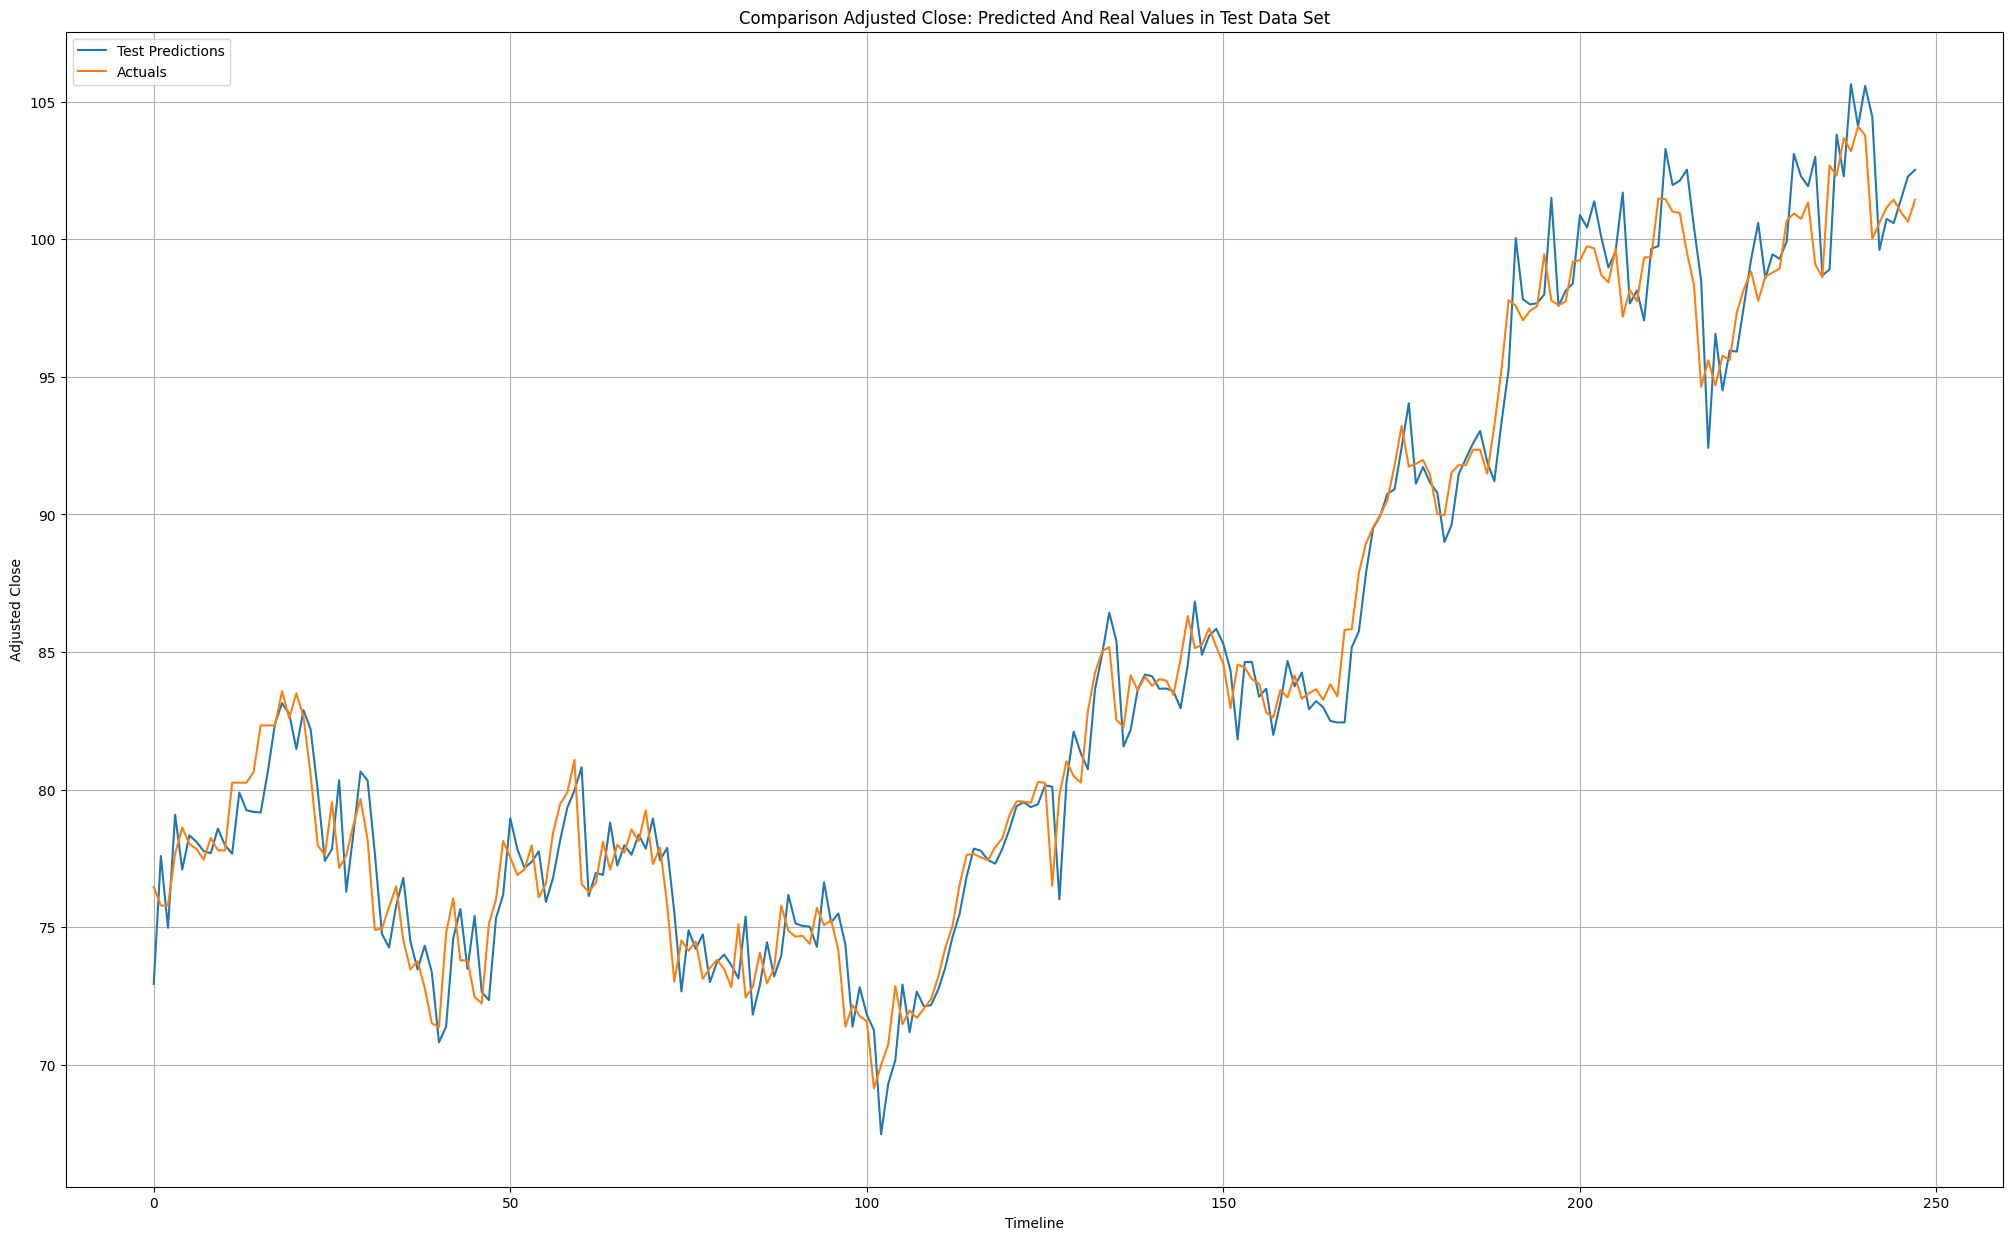

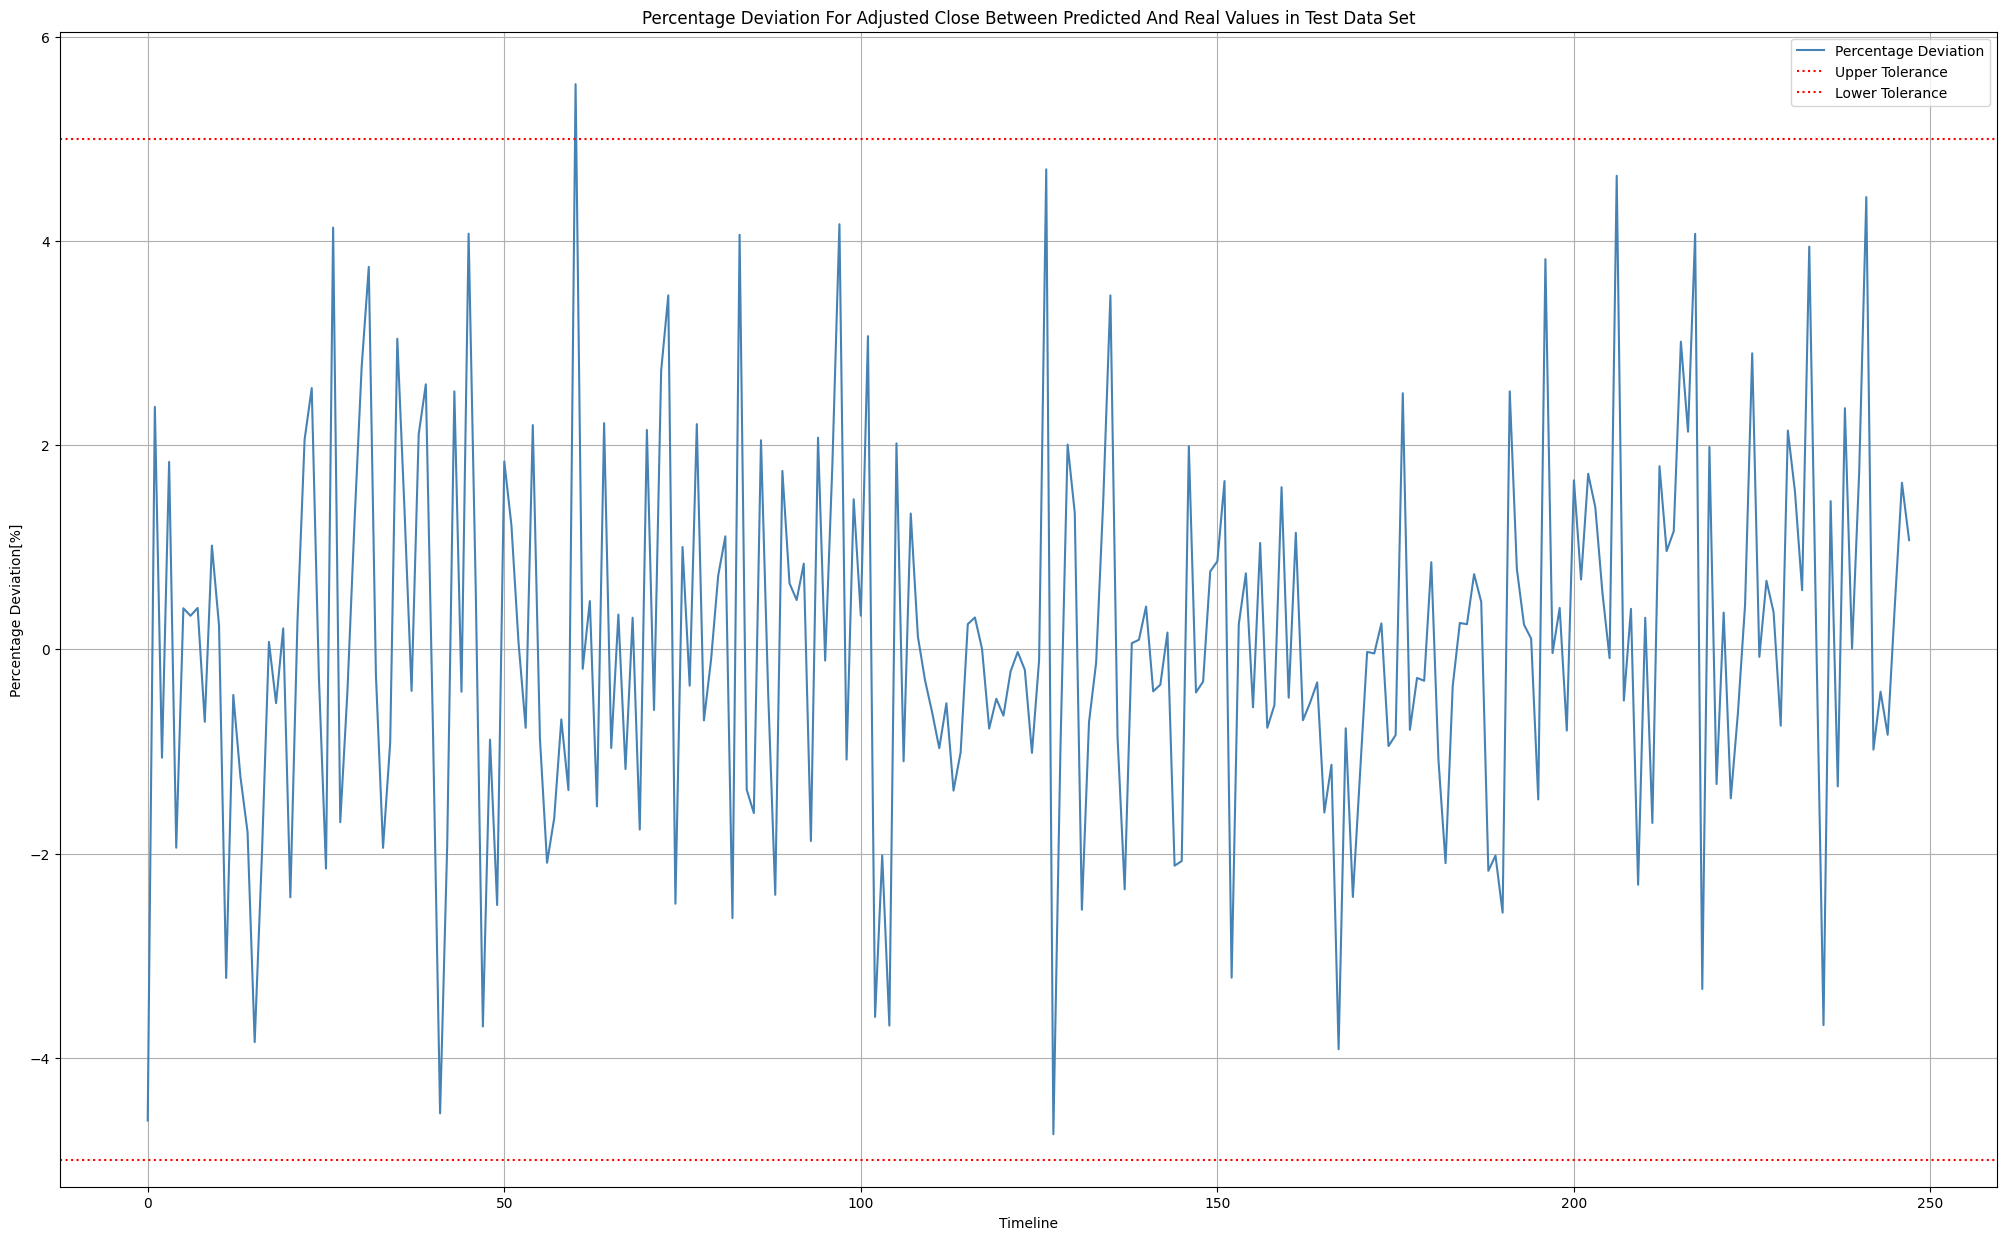

The mean for the percentage deviation in the test data is 1.4089135922549163.
-----------------------------------------


In [11]:
# showing the performance of the best model
model_validation(data, best_model)

The result is not bad. Let´s if it can be better with 11 more features.

***Information***: I´m aware, that with a loop of 10 don´t include all parameter constellations. Due to the training time, I decided this loop number. 

In [12]:
data = feat_eng(data)

In [18]:
# train the model with 17 features
best_model_17 = train_model(data, 10)

In [14]:
# show the best model components 
best_model_17

{'BMW.DE': {'model': <keras.engine.sequential.Sequential at 0x1040ee5f0>,
  'mse': 0.15748107433319092,
  'paramter': {'window_size': 20,
   'lstm_units': 32,
   'dense_units': 64,
   'learning_rate': 0.01}}}

8/8 [==============================] - 0s 2ms/step
######################
BMW.DE
######################
       Test Predictions     Actuals        diff       diff%
count        239.000000  239.000000  239.000000  239.000000
mean          84.542932   84.466611    0.076321    0.026932
std           10.586356    9.940982    1.713993    2.005203
min           70.390226   69.129997   -4.202604   -5.266421
25%           75.432570   76.375000   -1.093789   -1.326736
50%           81.542707   82.529999   -0.033665   -0.044906
75%           94.170762   93.225002    1.064691    1.244633
max          106.090042  104.099998    6.050509    6.151554


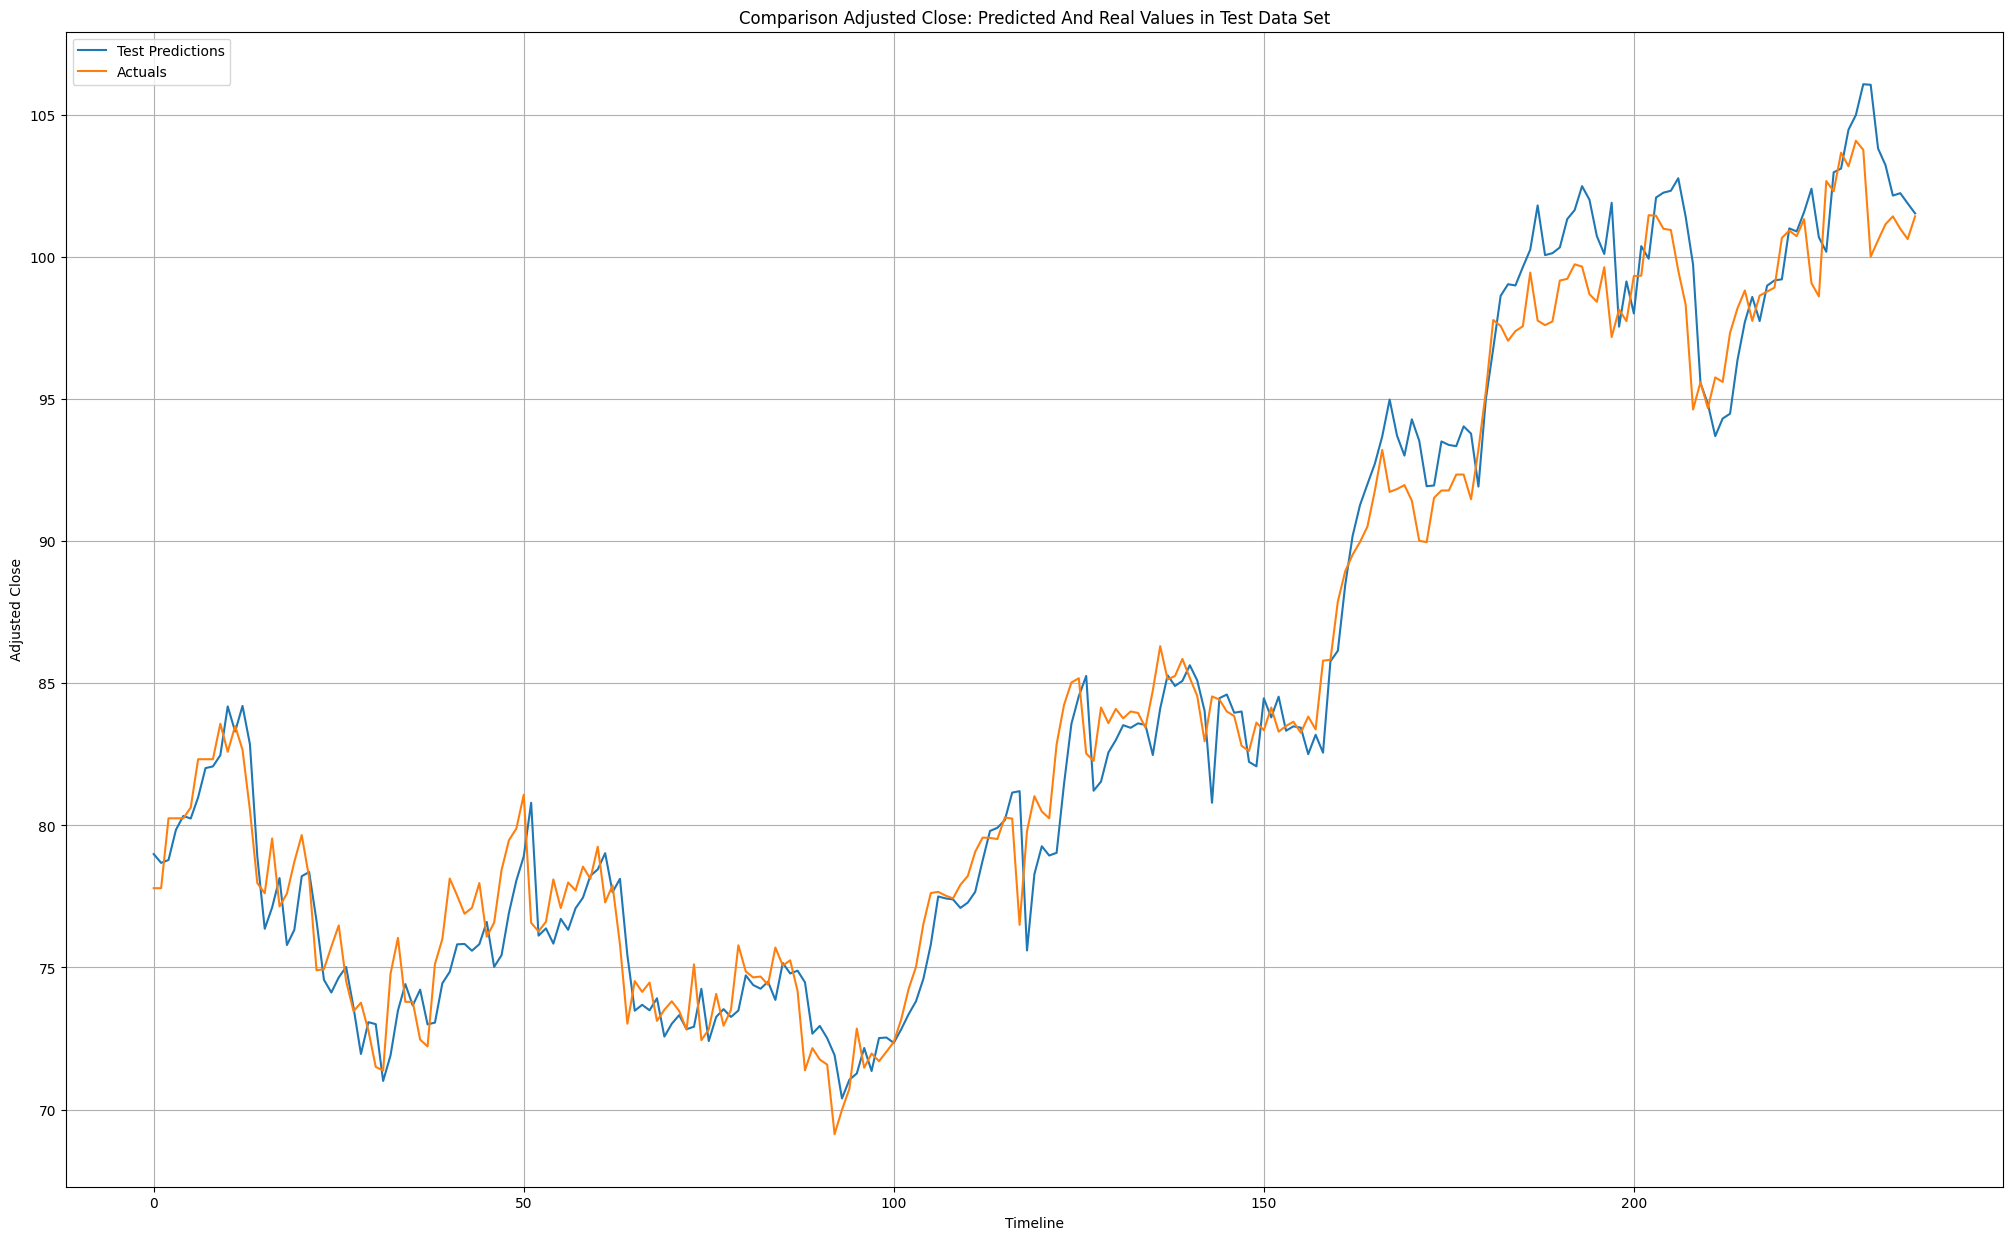

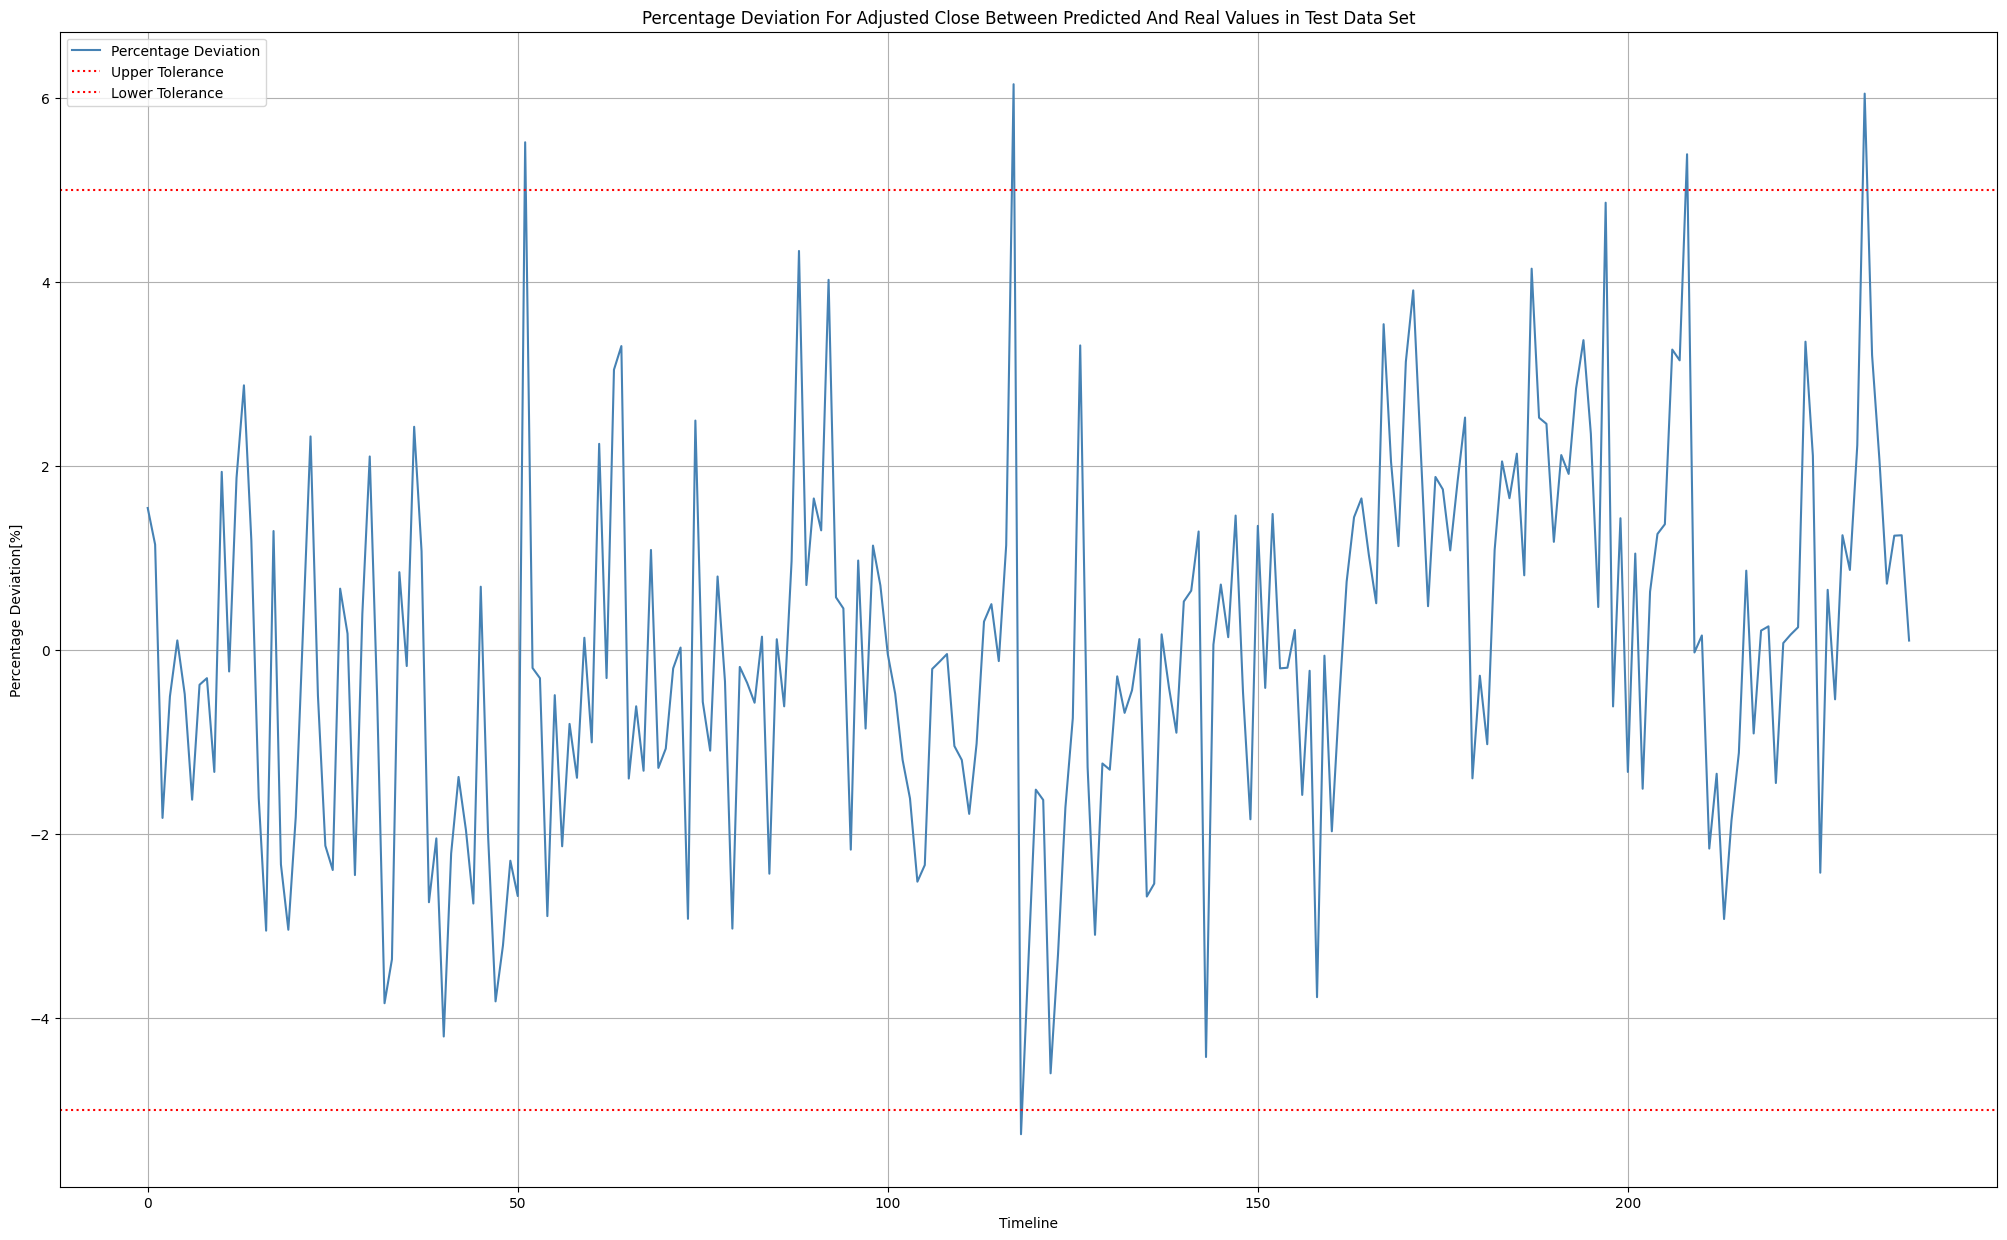

The mean for the percentage deviation in the test data is 1.5599344956867354.
-----------------------------------------


In [15]:
# showing the performance of the best model
model_validation(data, best_model_17)

The MSE with 17 features is worse than the MSE with 6 features. That's why my decision goes to the model with the 6 features.

## <a class="anchor" id="comparison"> 3. Comparison Stock Types </a>

In this chapter, I will do 20 trainings loops for all stocks and compare the prediction performance on the base of the stock type.

In [43]:
# load the data with 6 features
data = load_data('/Users/maximkiesel/PycharmProjects/Stock_Market_Prediction/data/cleaned_data.db')

Define a new train_model function, which iterate through all stocks.

In [44]:
def train_model(data, loops):
    '''
    Create new features (11) for the X dfs and clean potential Nan values.
    Adjusted the amount of y values.
    
    INPUT 
    data - (dict) Stock dfs with the new features
    loop - (int) Numbers of loops with randomized model parameter
      
    OUTPUT
    best_model - (dict) Stocks with following items:
    - 'model': Trained model
    - 'mse': Mean Squared Error for the best model
    - 'paramter': List of the parameter of the best model
    '''
    
    # define empty dict
    best_model = {}
    
    # define selection of parameters
    params = {
    'window_size': [4, 8, 12, 20],
    'lstm_units': [16, 32, 64, 128],
    'dense_units': [16, 32, 64, 128],
    'learning_rate': [0.0001, 0.001, 0.01, 0.1]
    }
    
    # iterate through the stock names
    for name in data:
        
        best_model[name] = {}
        
        # select the arrays
        df = data[name]
        
        # iterate through 
        for i in range(1,loops+1):

            random_params = {key: random.choice(values) for key, values in params.items()}

            X_train, X_val, X_test, test_mean, test_std, y_train, y_val, y_test, test_y_mean, test_y_std = data_split(df, random_params['window_size'])

            # define the model for the stock JNJ
            model = Sequential()
            model.add(InputLayer((random_params['window_size'], X_train.shape[-1]))) # the first parameter is always the window size, the second the number of features
            model.add(LSTM(random_params['lstm_units']))
            model.add(Dense(random_params['dense_units'], 'relu'))
            model.add(Dense(X_train.shape[-1], 'linear')) # output of 17 features
            model.compile(loss=MeanSquaredError(), optimizer=Adam(learning_rate=random_params['learning_rate']), metrics=[RootMeanSquaredError()])
    
            # create a model checkpoint for the best model
            cp = ModelCheckpoint('model/keras_model', save_best_only=True, verbose=0)
            
            # fitting the model
            history = model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=100, callbacks=[cp], verbose=0)
    
            # load the best model
            model = load_model('model/keras_model')
            
            # get the best mse from the best model
            best_mse = history.history['val_loss'][np.argmin(history.history['val_loss'])]
            
            # if this is the first window size, set the accuracy to the current percent difference
            if i == 1:
                
                best_model[name]['model'] = model
                best_model[name]['mse'] = best_mse
                best_model[name]['paramter'] = random_params
            
            # otherwise, compare the current accuracy to the previous best accuracy and update if necessary
            else:
                
                if best_model[name]['mse'] > best_mse:
                    
                    best_model[name]['model'] = model
                    best_model[name]['mse'] = best_mse
                    best_model[name]['paramter'] = random_params
                
                else:
                    
                    continue
        
    return best_model

In [53]:
# train the model
best_models = train_model(data, 10)

In [46]:
# show the best model components 
best_models

{'BMW.DE': {'model': <keras.engine.sequential.Sequential at 0x29c03ea70>,
  'mse': 0.14576256275177002,
  'paramter': {'window_size': 4,
   'lstm_units': 16,
   'dense_units': 128,
   'learning_rate': 0.001}},
 'BTC-USD': {'model': <keras.engine.sequential.Sequential at 0x29ff30610>,
  'mse': 0.1309232860803604,
  'paramter': {'window_size': 8,
   'lstm_units': 16,
   'dense_units': 128,
   'learning_rate': 0.001}},
 'ETSY': {'model': <keras.engine.sequential.Sequential at 0x29d5abbe0>,
  'mse': 0.12876926362514496,
  'paramter': {'window_size': 4,
   'lstm_units': 16,
   'dense_units': 128,
   'learning_rate': 0.01}},
 'JNJ': {'model': <keras.engine.sequential.Sequential at 0x29a2f2440>,
  'mse': 0.17460310459136963,
  'paramter': {'window_size': 4,
   'lstm_units': 128,
   'dense_units': 64,
   'learning_rate': 0.01}},
 'TSLA': {'model': <keras.engine.sequential.Sequential at 0x28a01acb0>,
  'mse': 0.14575409889221191,
  'paramter': {'window_size': 20,
   'lstm_units': 16,
   'dense_

8/8 [==============================] - 0s 992us/step
######################
BMW.DE
######################
       Test Predictions     Actuals        diff       diff%
count        248.000000  248.000000  248.000000  248.000000
mean          84.149570   84.207137   -0.057567   -0.010872
std            9.521193    9.851573    1.439396    1.762136
min           69.283809   69.129997   -5.040960   -4.909388
25%           76.465971   76.412504   -0.946918   -1.123519
50%           81.639157   81.674999    0.012759    0.015750
75%           92.114307   92.349998    0.693536    0.898152
max          103.101547  104.099998    4.671582    6.101061


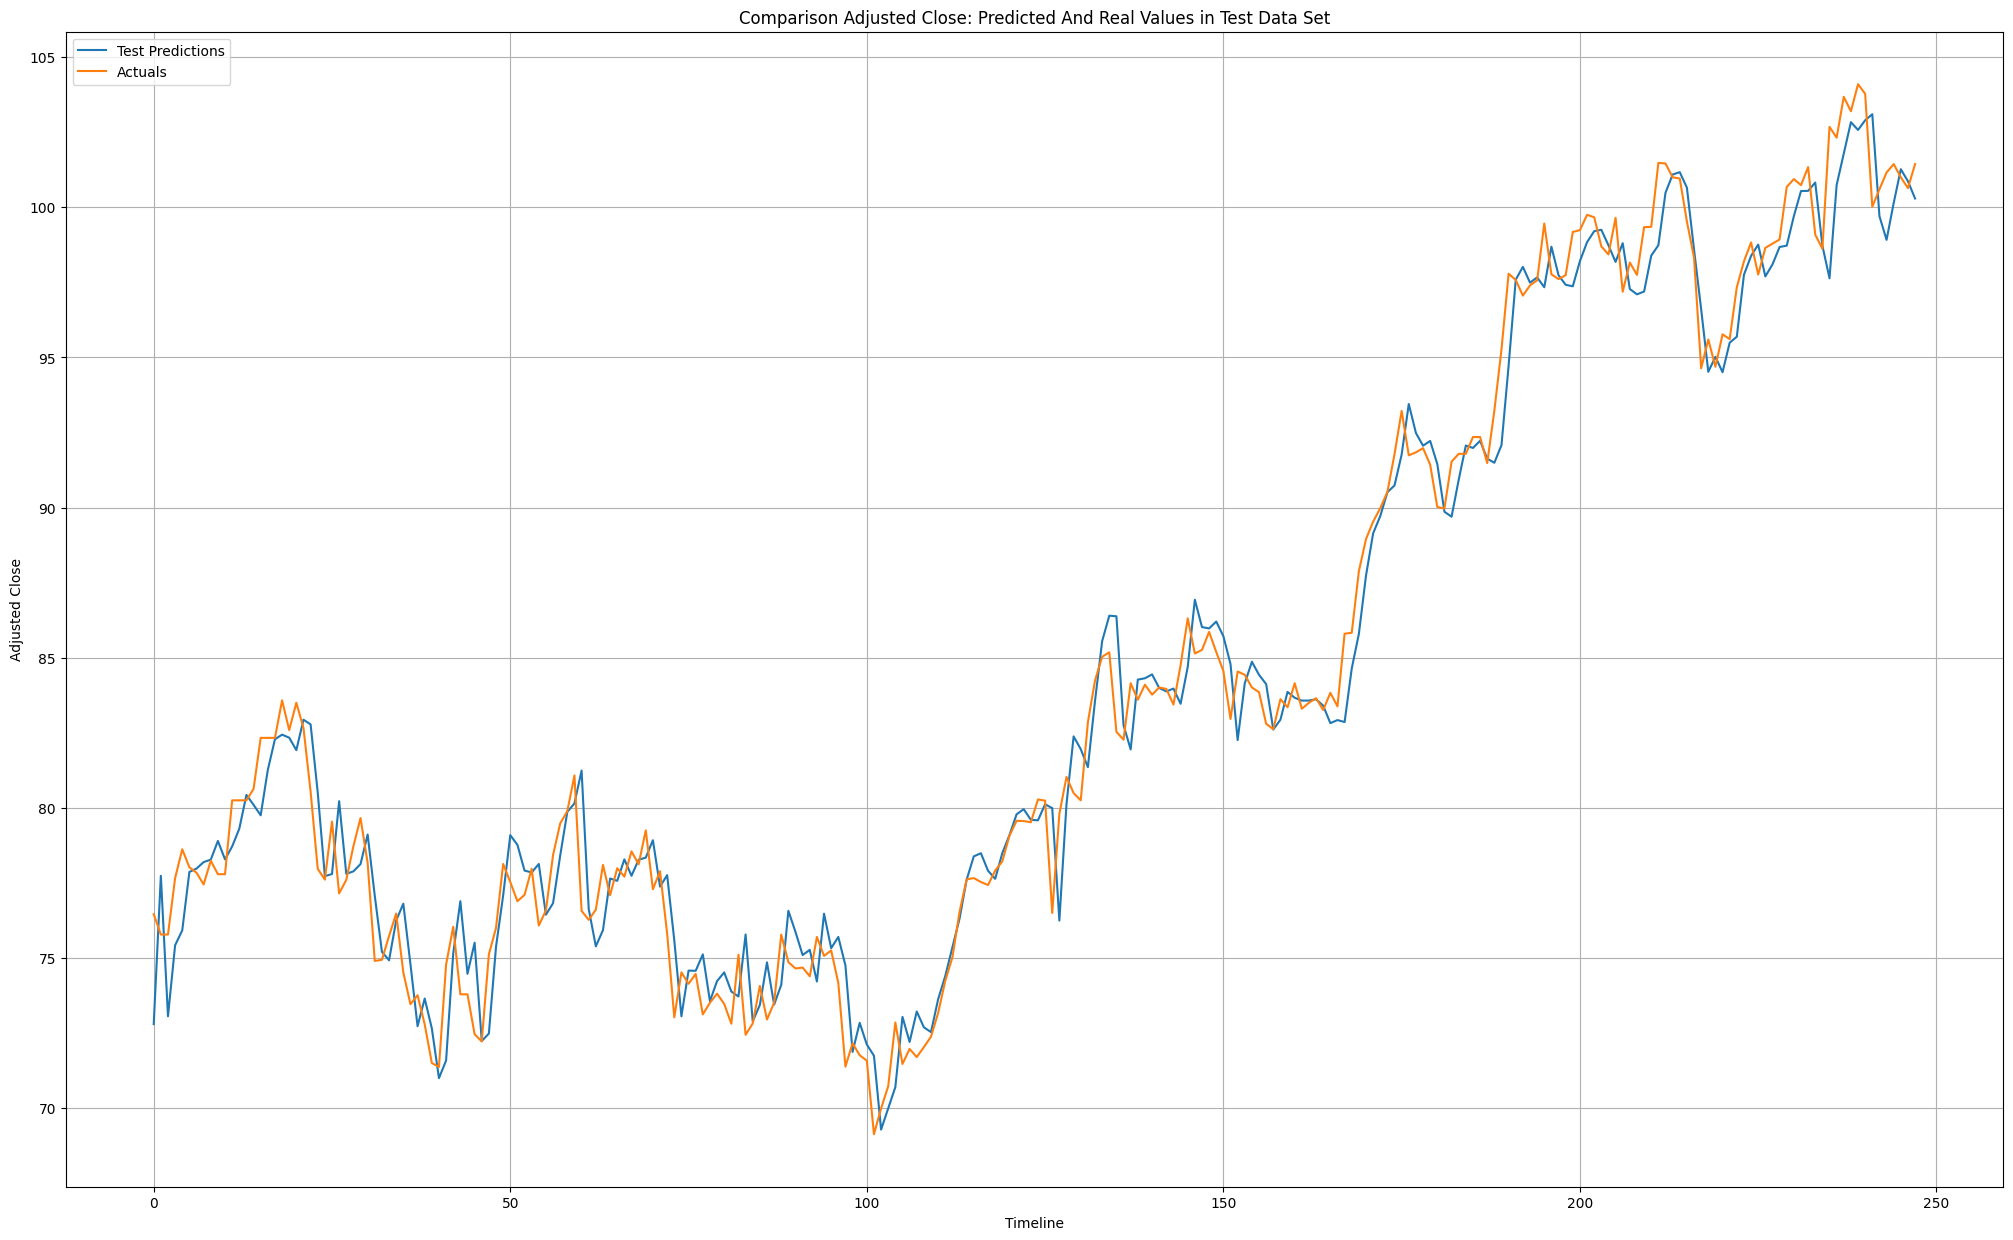

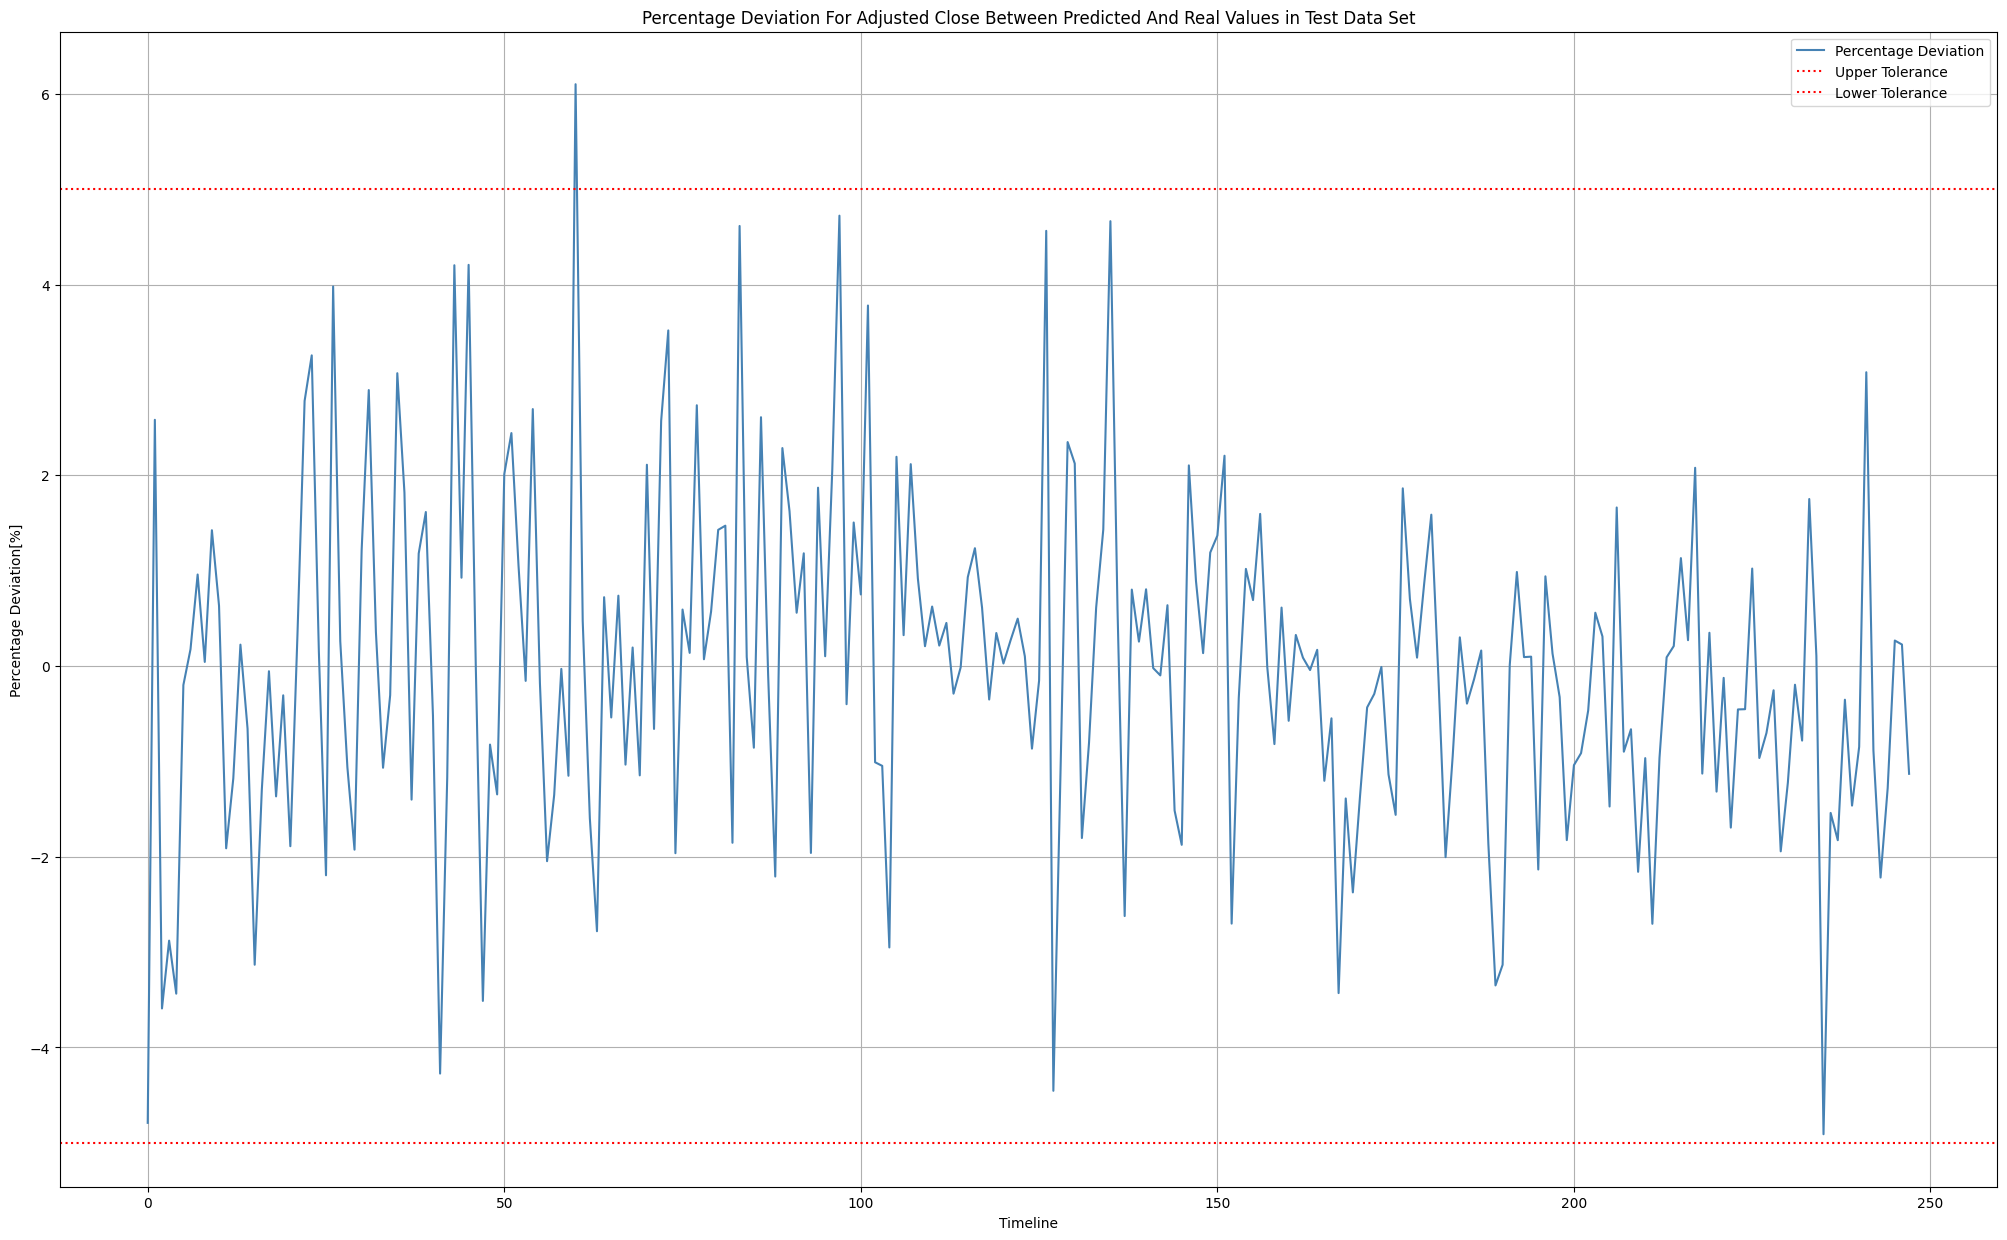

The mean for the percentage deviation in the test data is 1.3089789029498362.
-----------------------------------------
12/12 [==============================] - 0s 956us/step
######################
BTC-USD
######################
       Test Predictions       Actuals         diff       diff%
count        361.000000    361.000000   361.000000  361.000000
mean       22876.489349  22536.881084   339.608265    1.659313
std         4628.631750   4554.389225  1011.178412    4.527530
min        17318.075836  15787.284180 -3355.231290  -13.866006
25%        19557.878433  19329.833984  -199.343244   -0.832472
50%        21307.926990  21528.087891   385.643588    1.654511
75%        24833.950638  24565.601562   819.160027    4.020830
max        39192.946558  39698.371094  5812.667642   25.848567


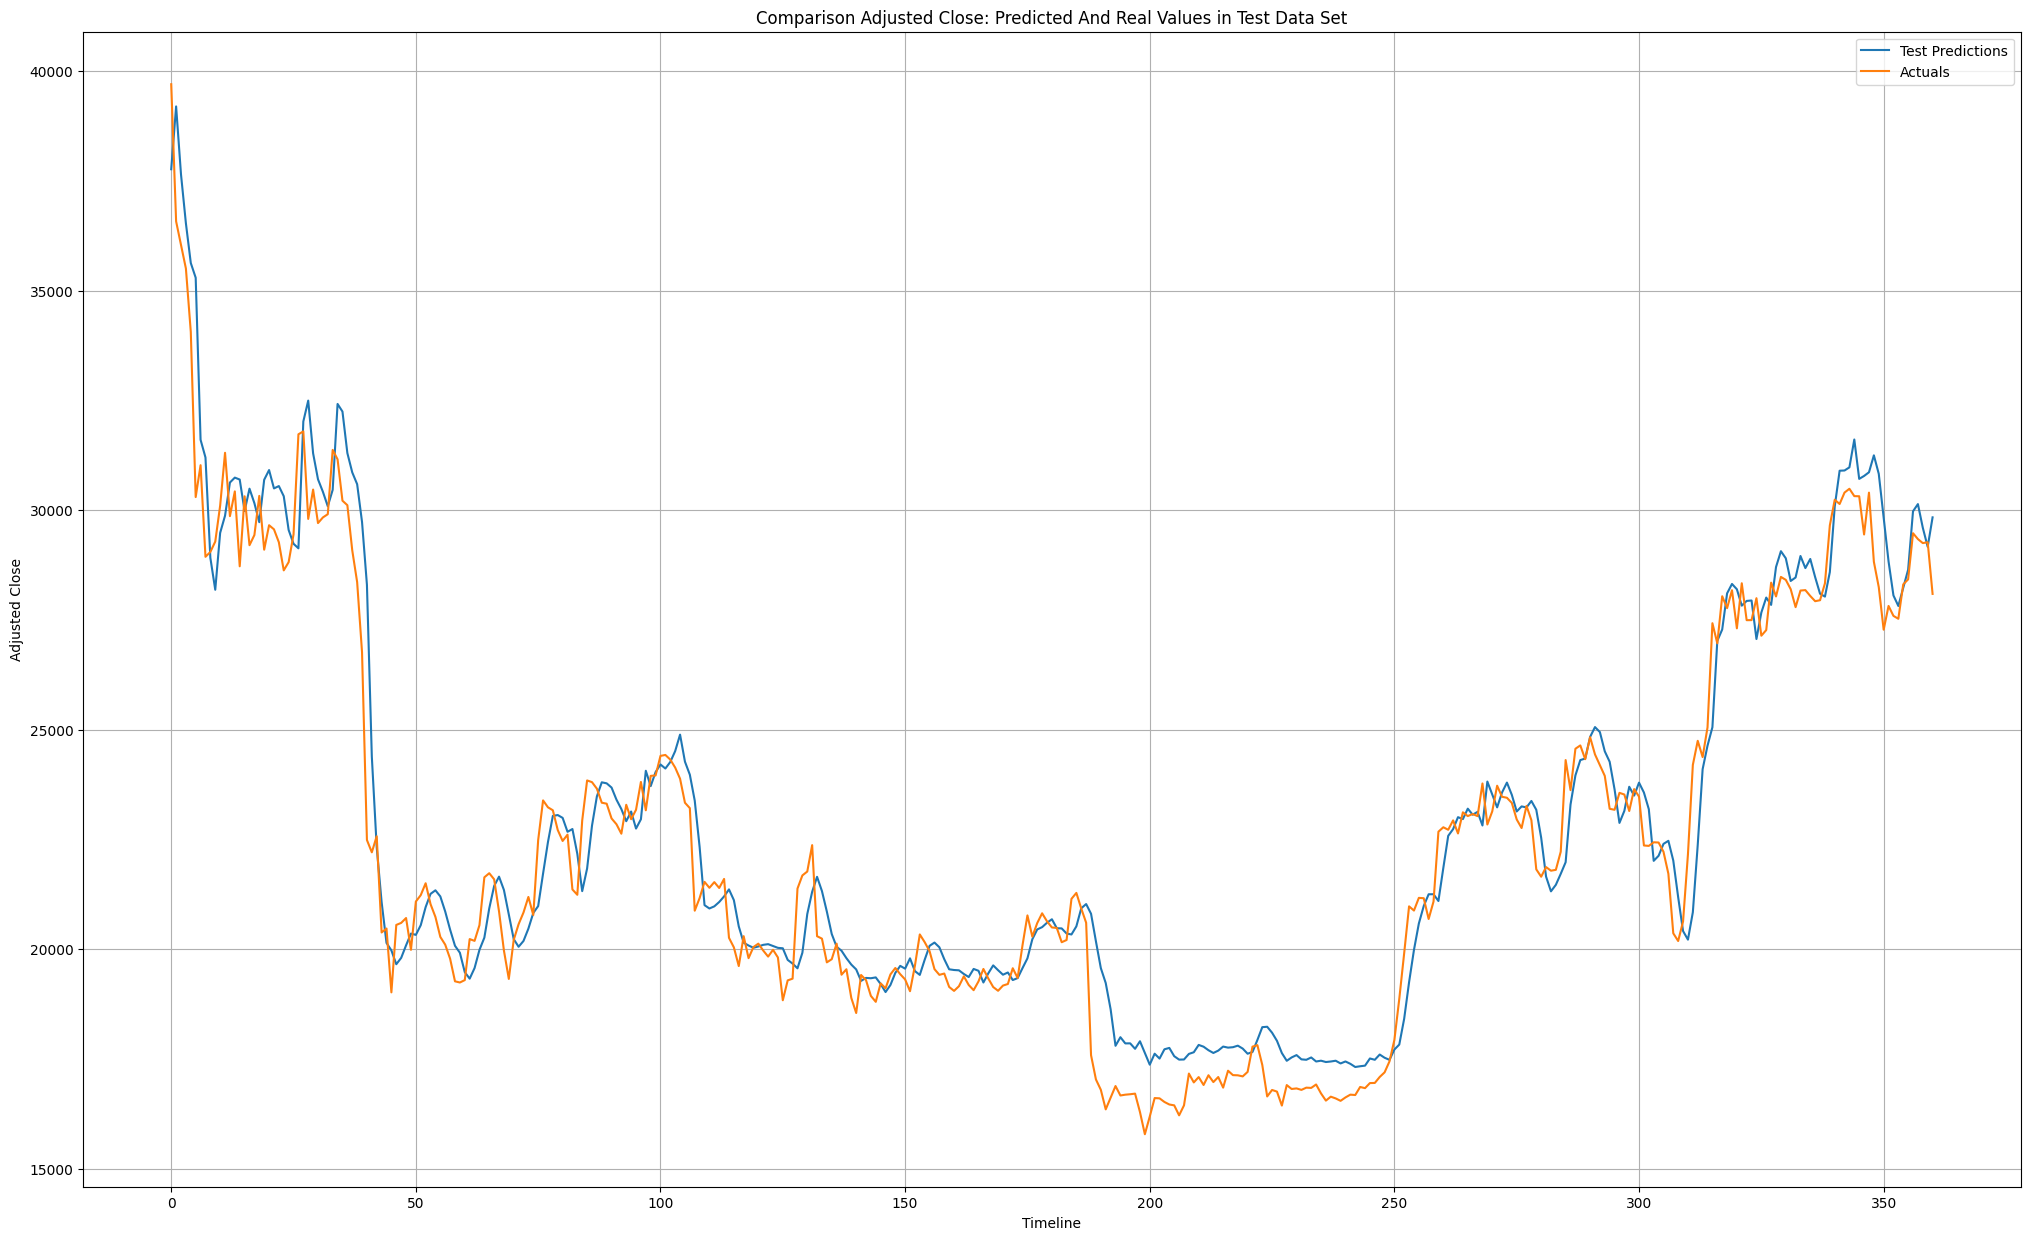

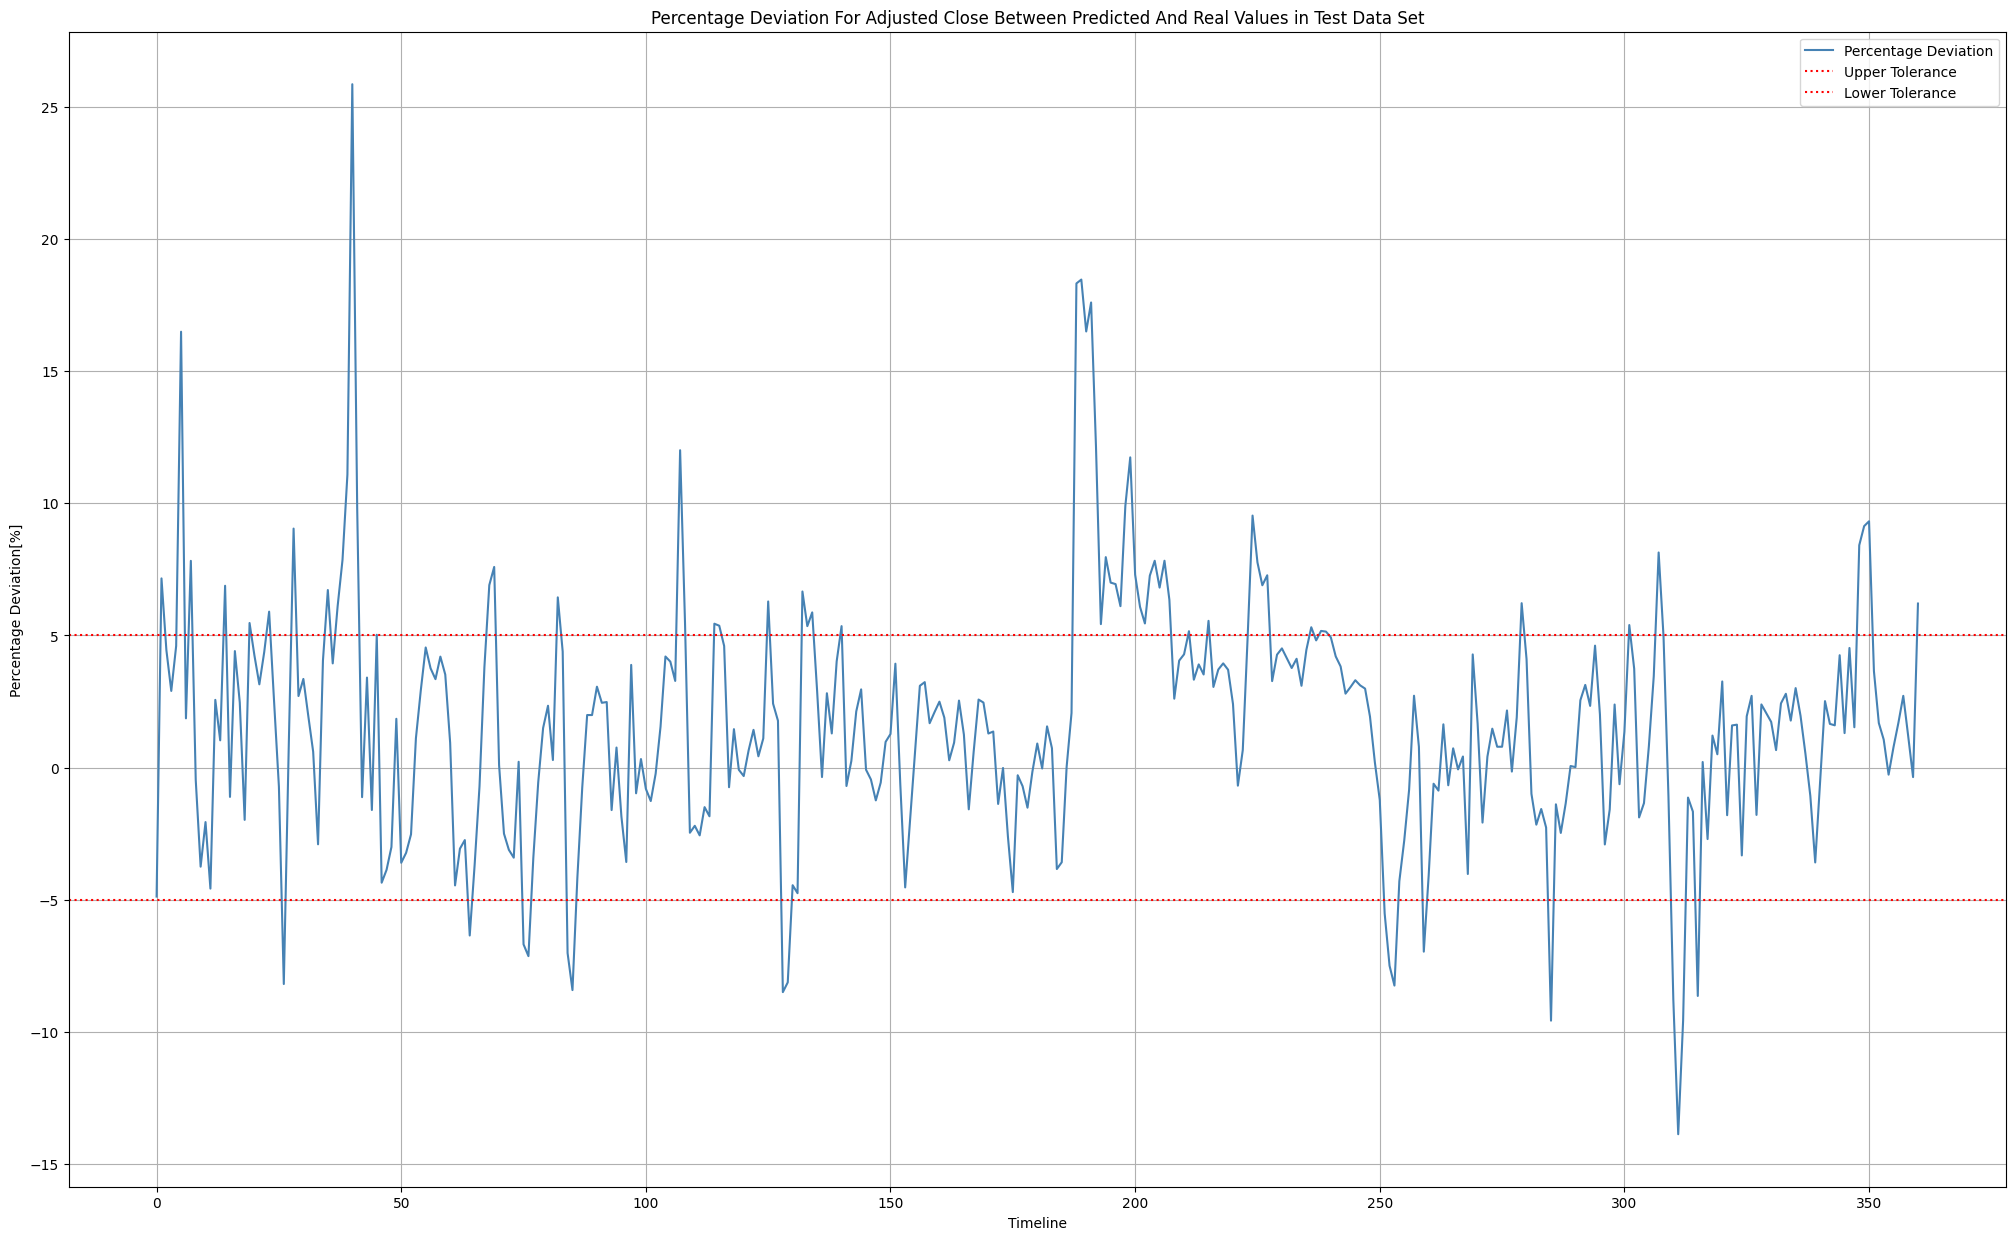

The mean for the percentage deviation in the test data is 3.55125760030708.
-----------------------------------------
8/8 [==============================] - 0s 954us/step
######################
ETSY
######################
       Test Predictions     Actuals        diff       diff%
count        248.000000  248.000000  248.000000  248.000000
mean         107.567867  107.290040    0.277826    0.514674
std           17.552404   18.378099    4.503256    4.576301
min           73.630414   69.000000  -12.262299  -11.126303
25%           96.471682   96.470001   -2.326153   -2.171713
50%          106.308587  105.840000    0.088935    0.076467
75%          119.054197  120.069998    3.300609    3.307279
max          145.640693  148.199997   21.038744   24.356037


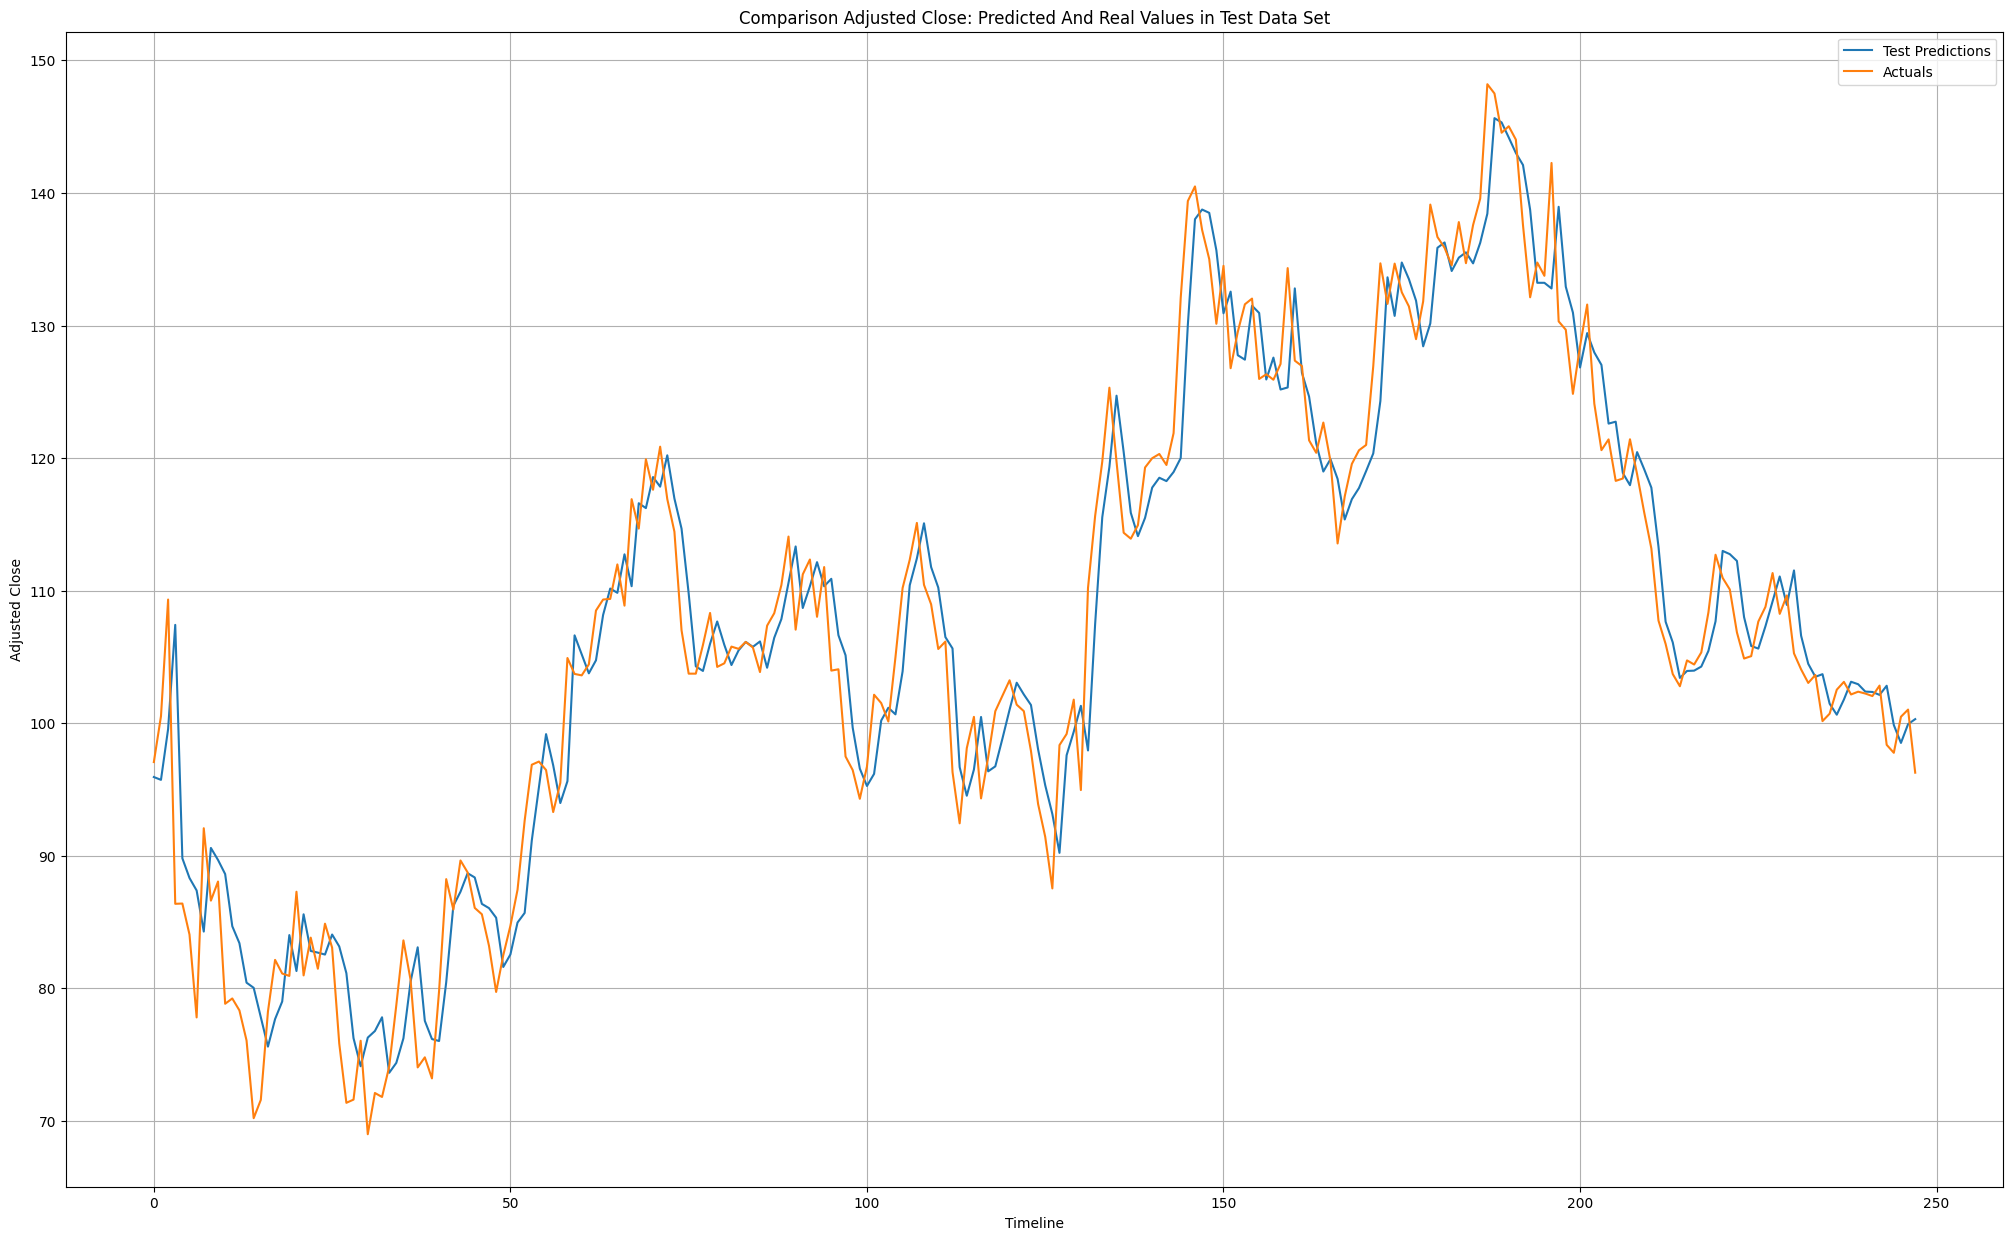

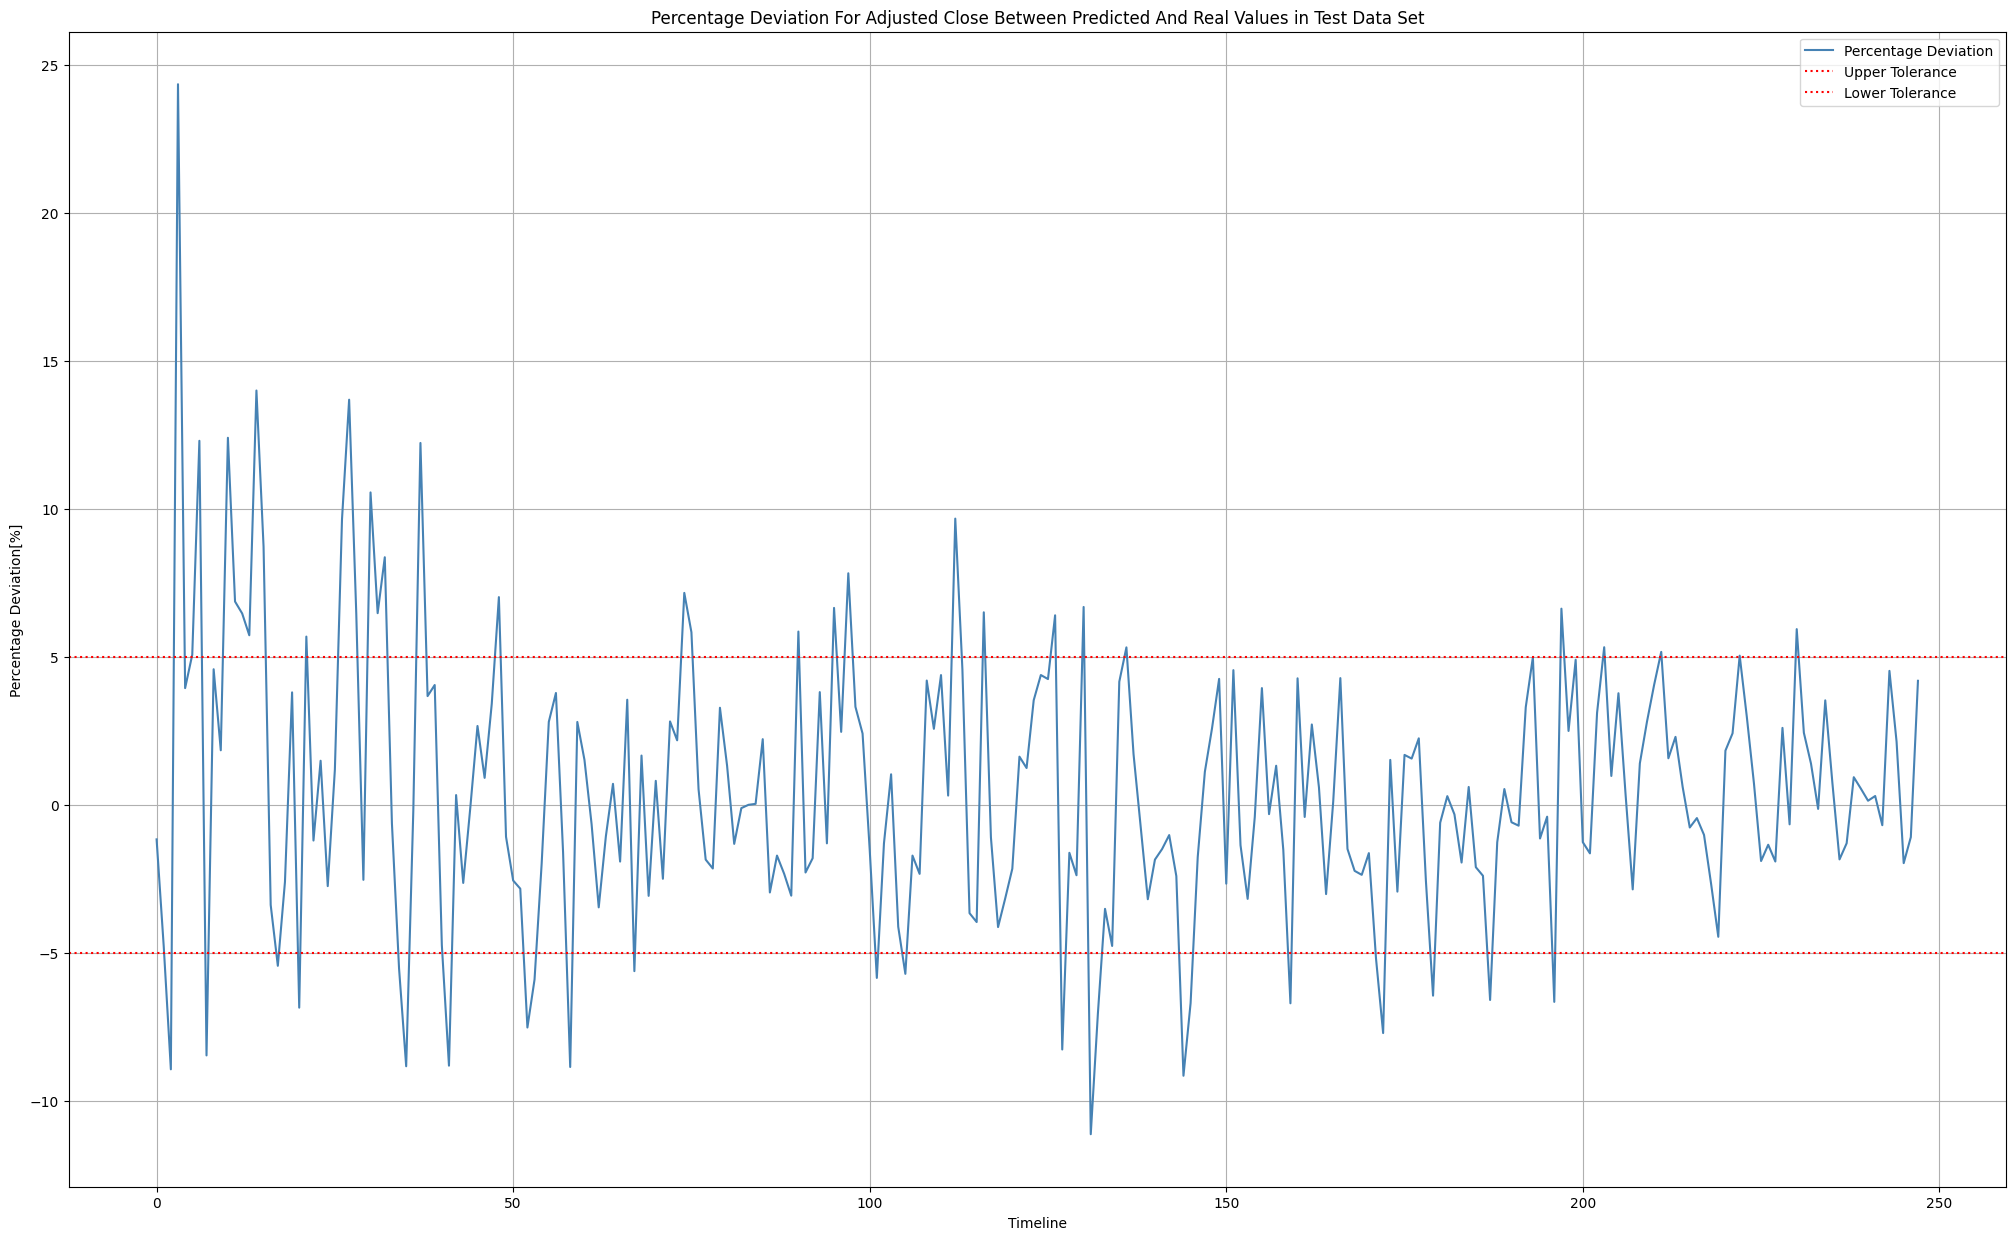

The mean for the percentage deviation in the test data is 3.4435542733089504.
-----------------------------------------
8/8 [==============================] - 0s 1ms/step
######################
JNJ
######################
       Test Predictions     Actuals        diff       diff%
count        246.000000  246.000000  246.000000  246.000000
mean         166.791701  166.976377   -0.184676   -0.102735
std            7.106864    7.175493    1.848437    1.108947
min          152.203863  151.050003   -8.039445   -4.854444
25%          161.943967  162.447563   -1.386751   -0.805164
50%          166.956017  167.260422   -0.295385   -0.177200
75%          173.186776  173.334457    0.995187    0.584567
max          178.698058  178.962830    4.526503    2.844162


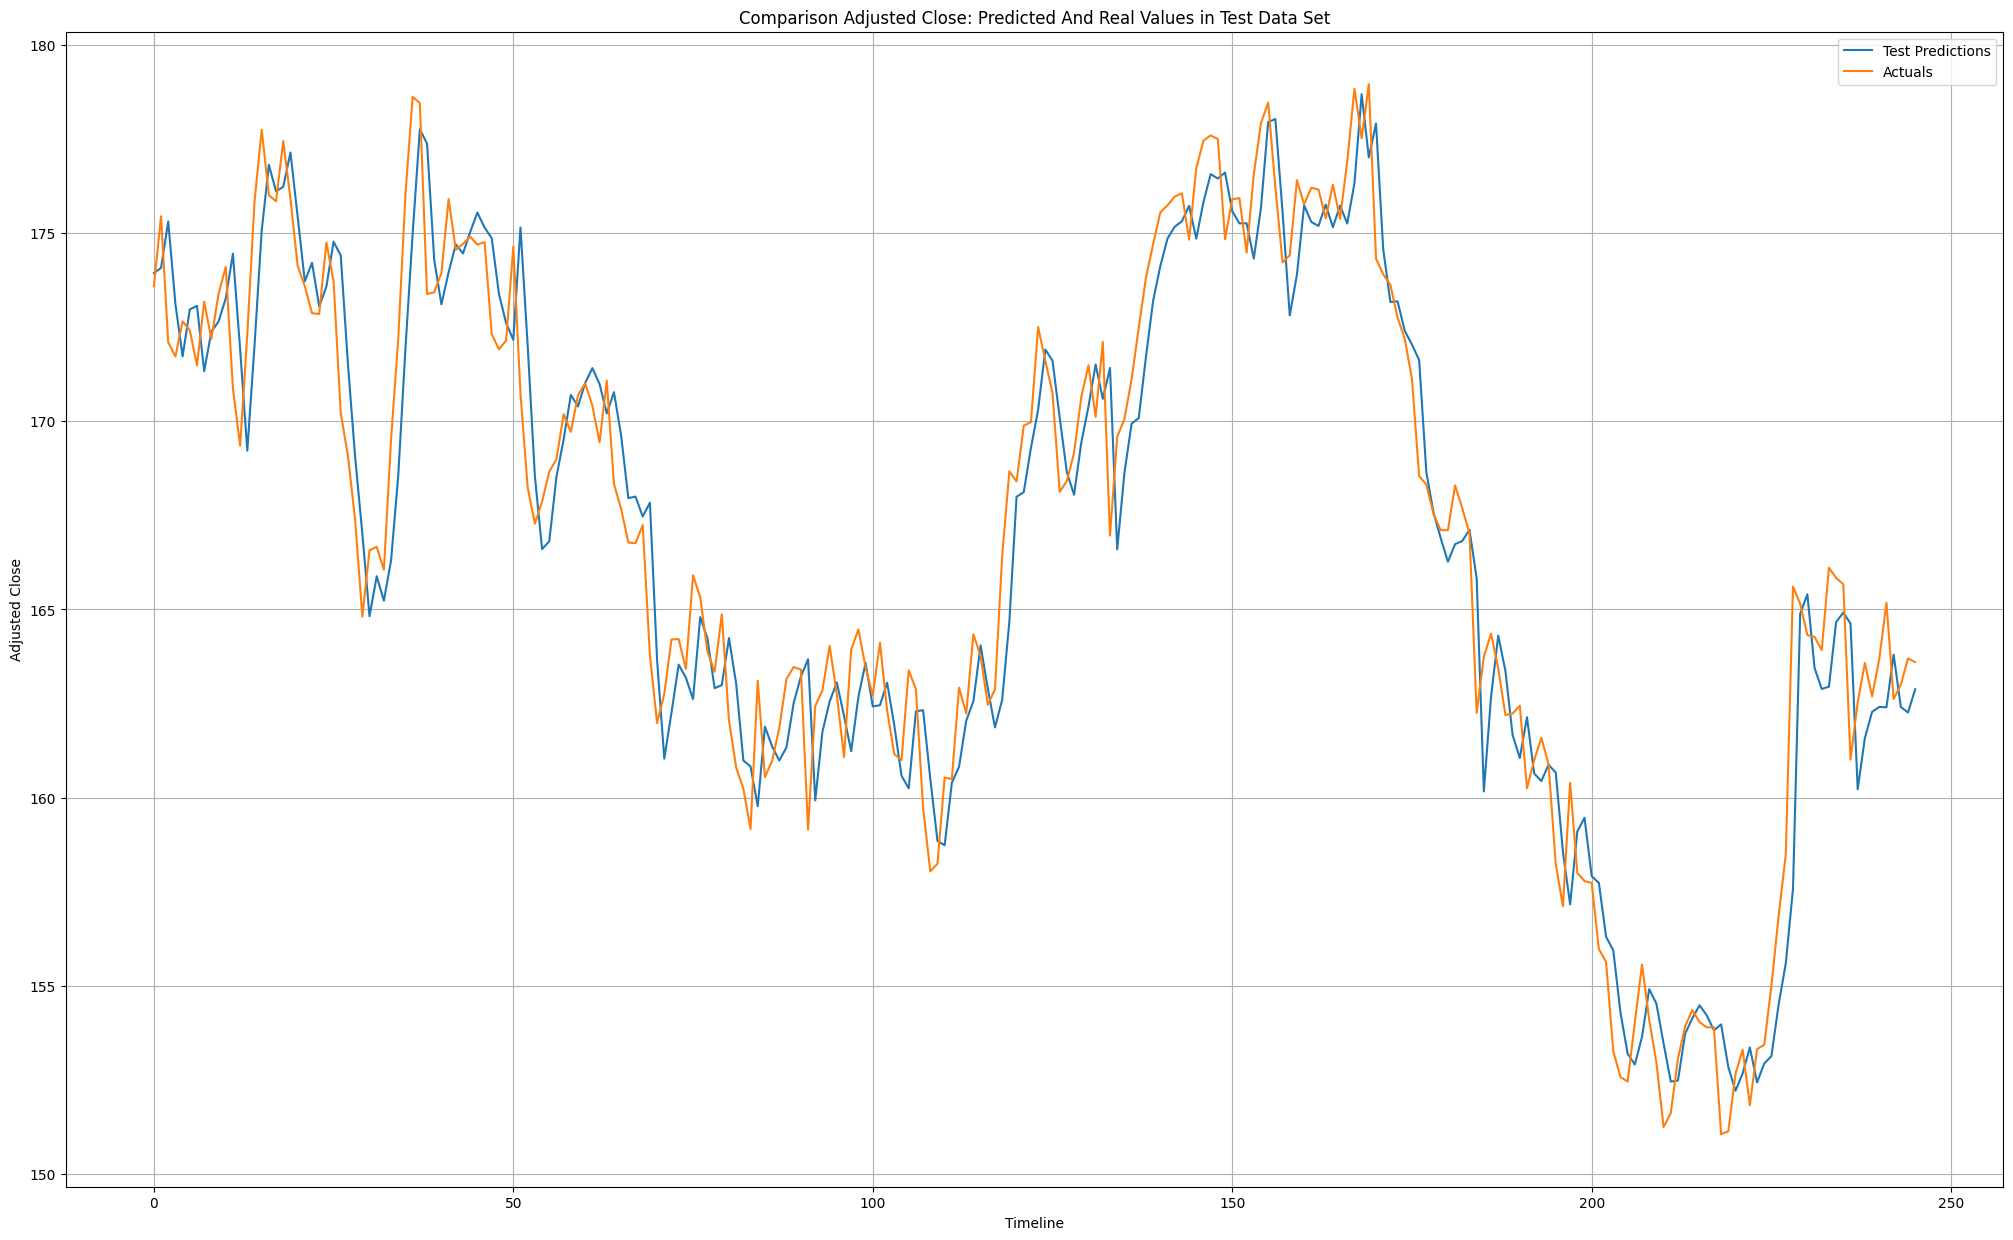

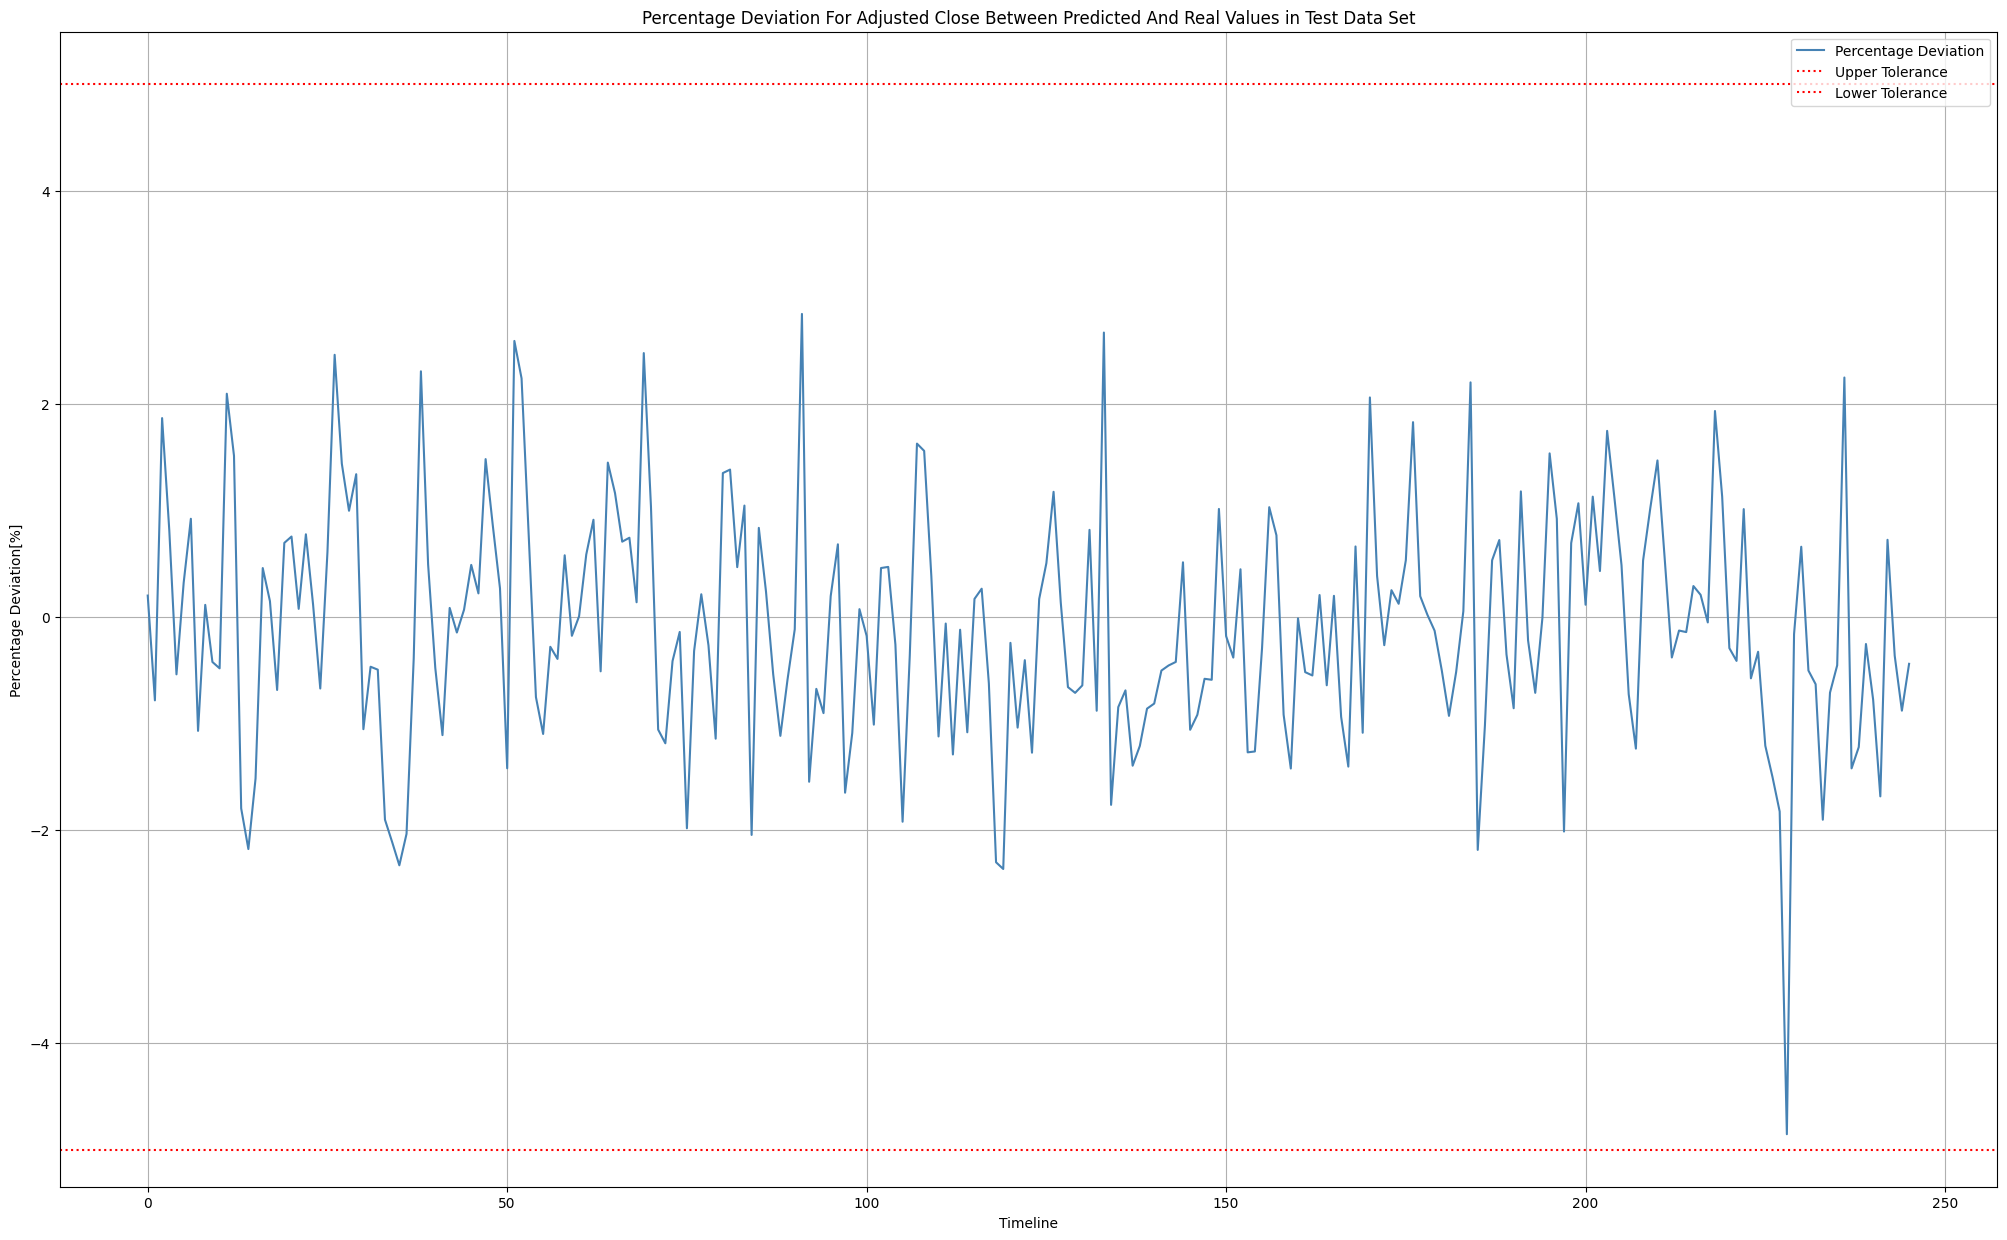

The mean for the percentage deviation in the test data is 0.8756215398126789.
-----------------------------------------
8/8 [==============================] - 0s 1ms/step
######################
TSLA
######################
       Test Predictions     Actuals        diff       diff%
count        244.000000  244.000000  244.000000  244.000000
mean         215.905961  214.694659    1.211302    1.455053
std           46.586331   51.024051   11.521016    7.074213
min          136.861071  108.099998  -35.438547  -19.920488
25%          182.706451  182.757500   -6.632817   -2.748567
50%          209.543731  209.318336   -0.017504   -0.009903
75%          247.170454  245.574165    9.385558    4.391769
max          305.688555  309.320007   36.564614   33.514770


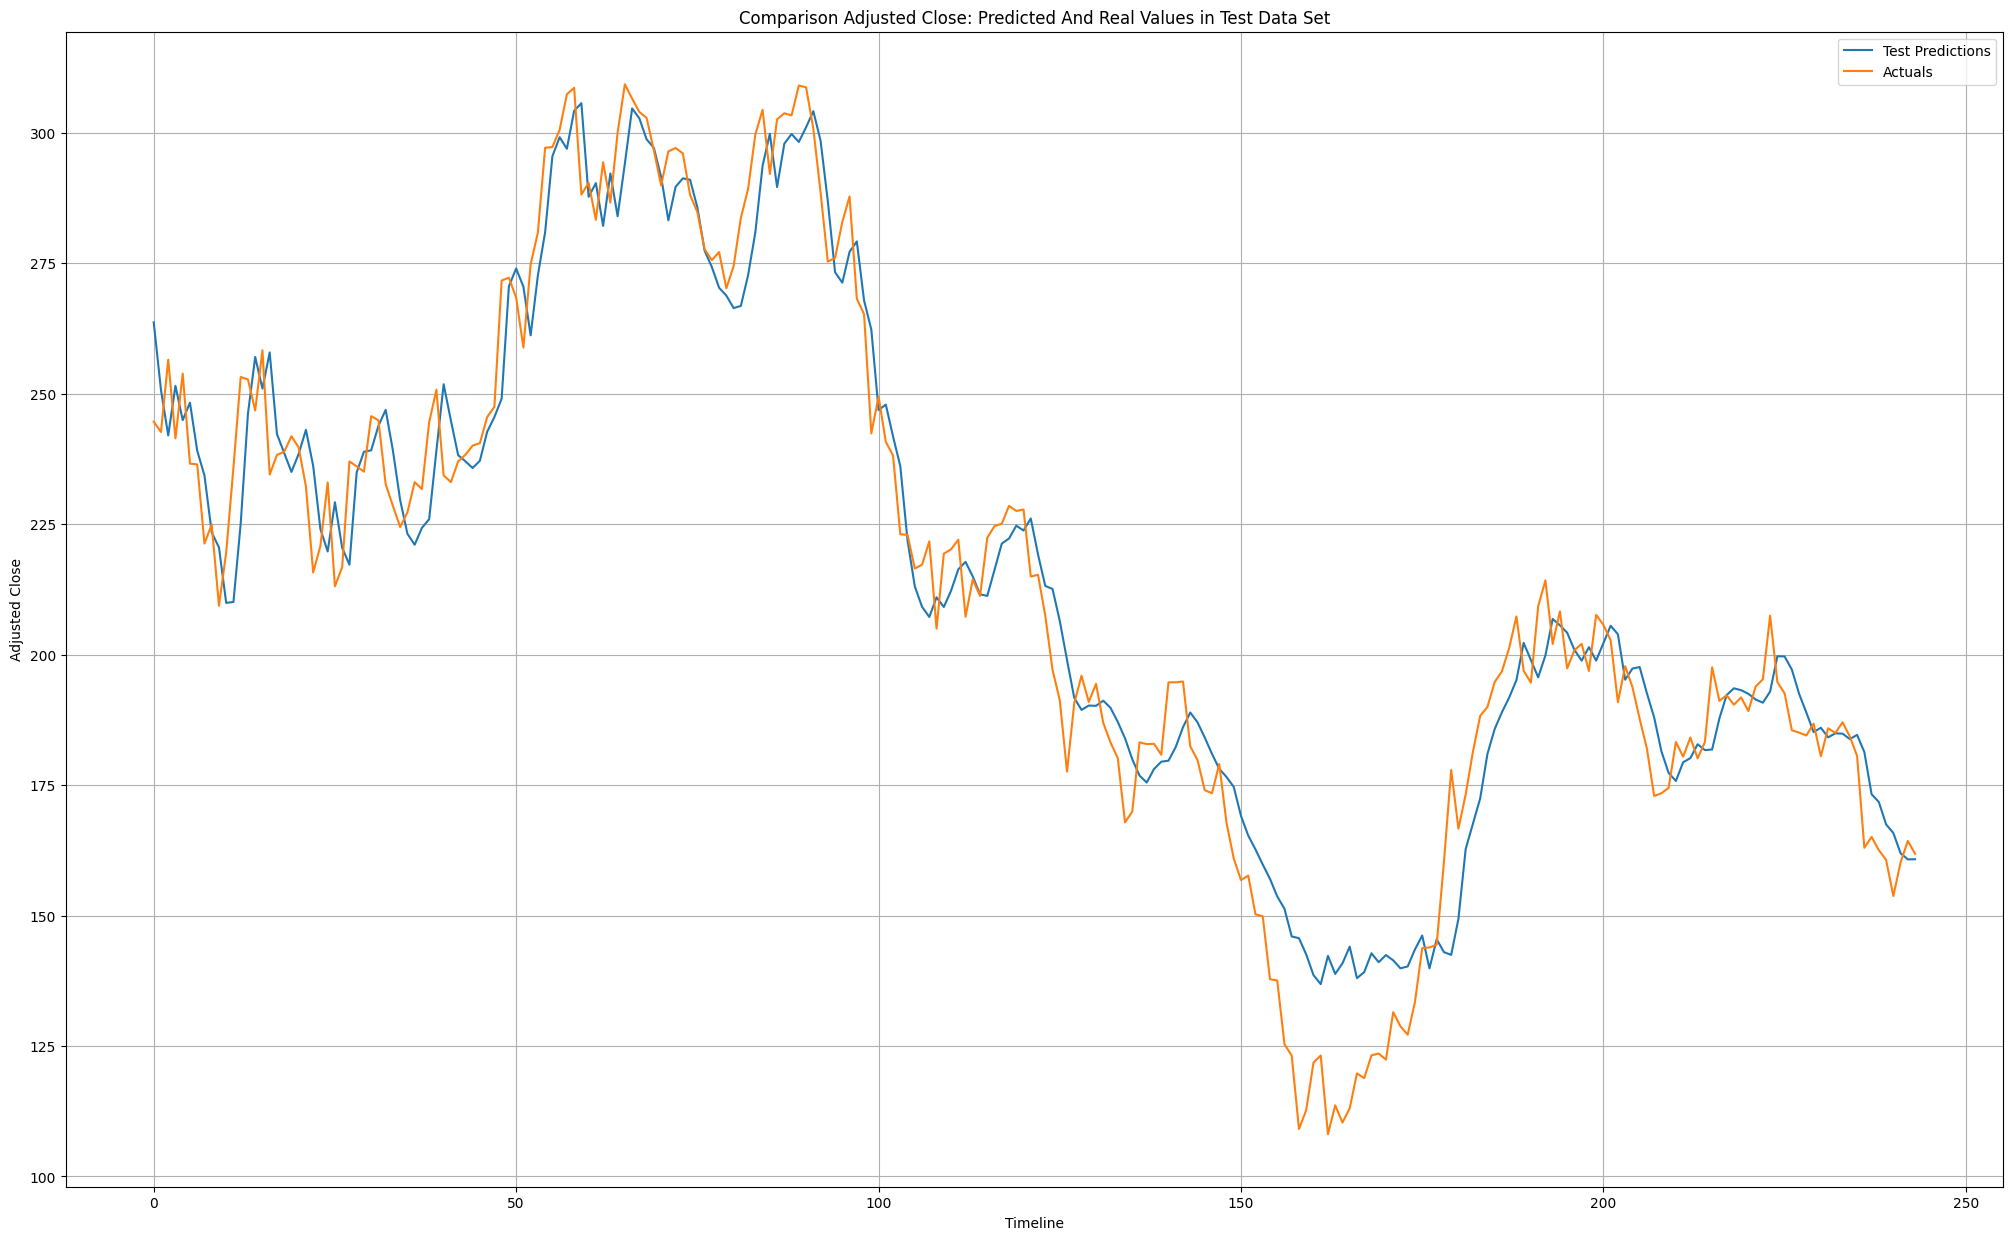

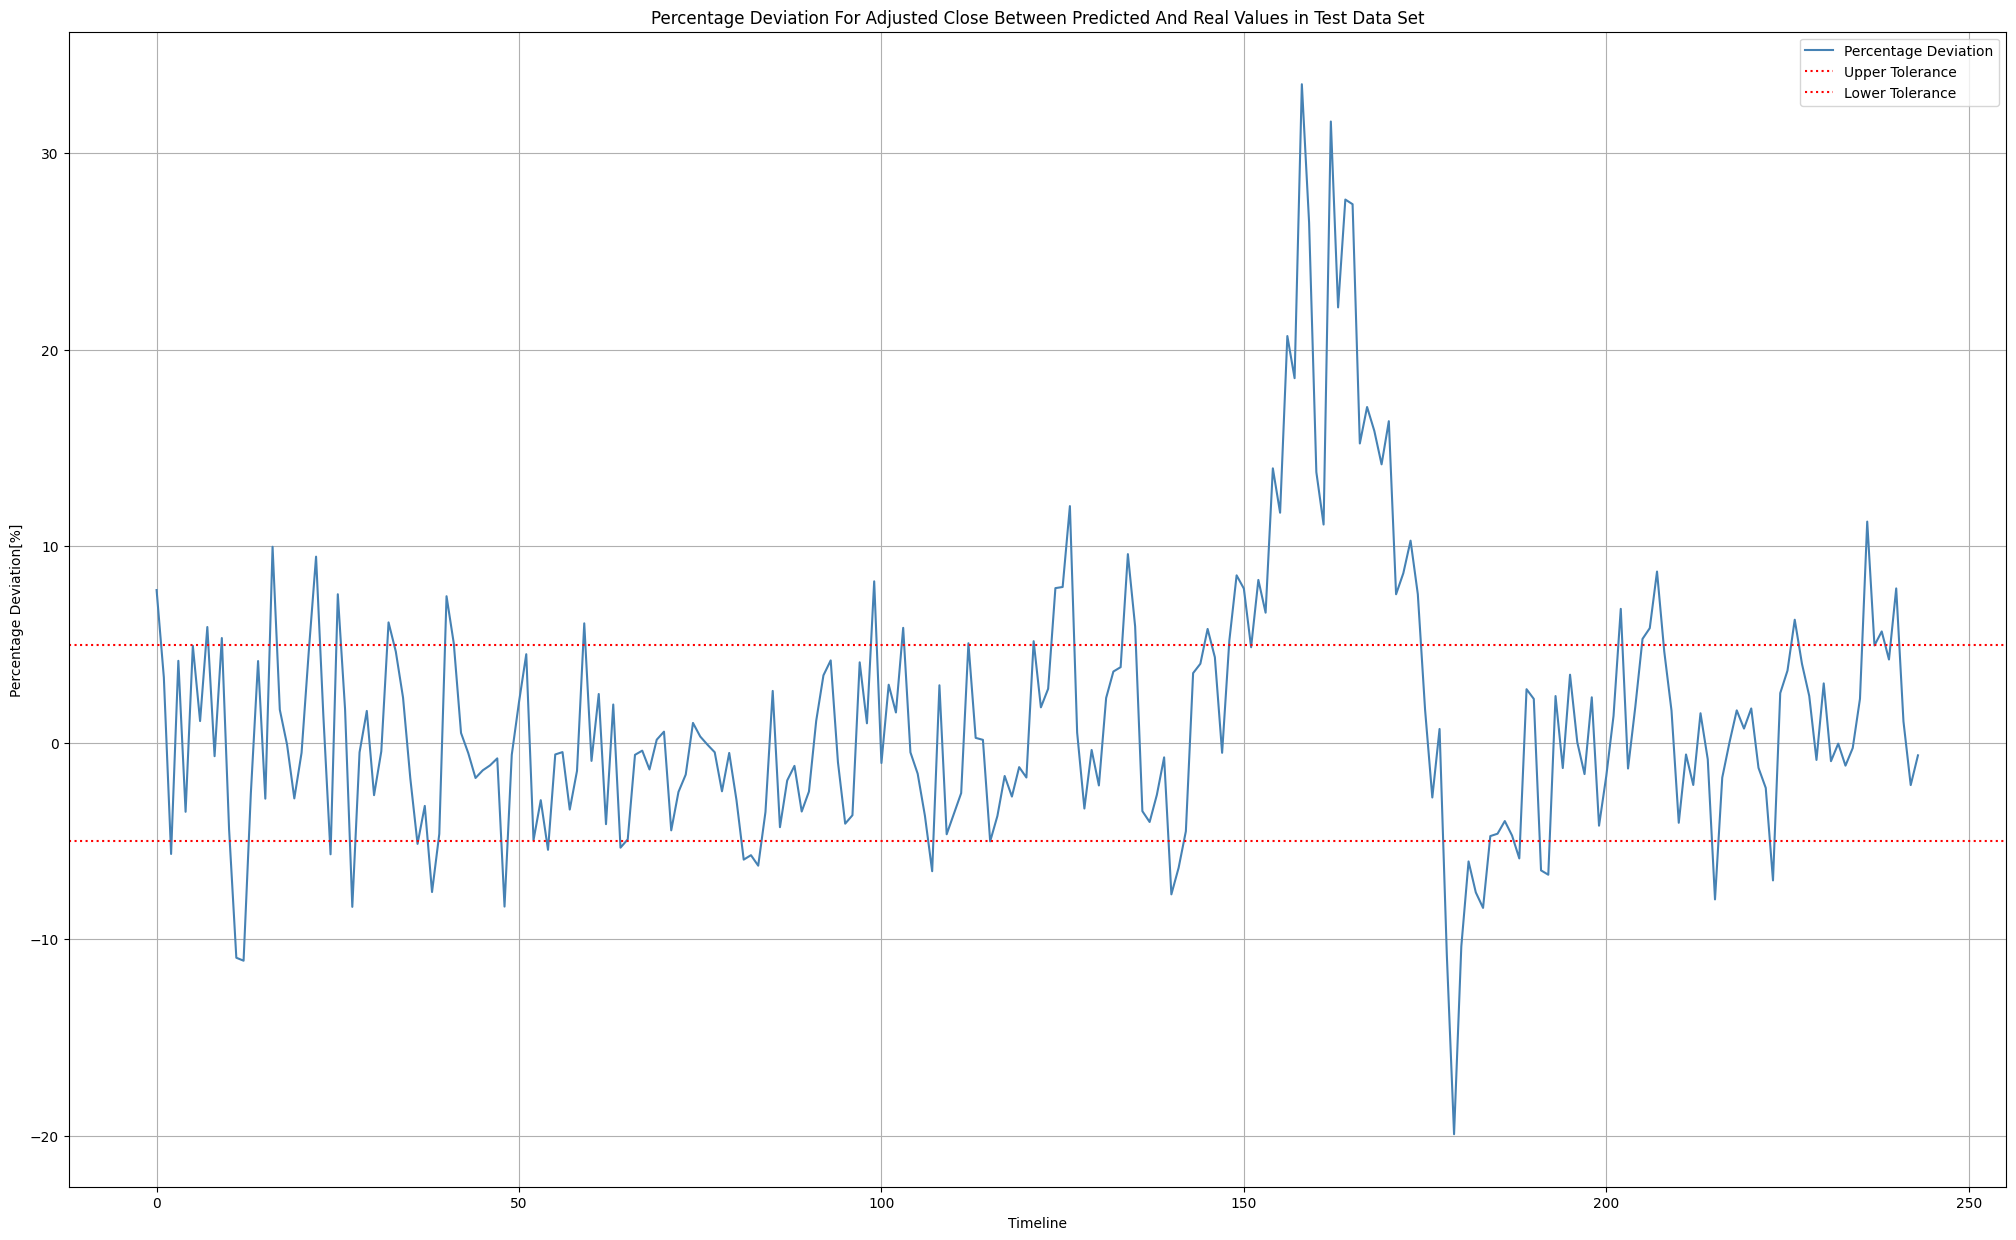

The mean for the percentage deviation in the test data is 4.887543248847609.
-----------------------------------------


In [47]:
# showing the performance of the best model
model_validation(data, best_models)

It can be seen, that the growth stocks and the small-cap stocks are worse than blue-chip and dividend stocks.

## <a class="anchor" id="plstm"> 4. Prediction With LSTM </a>

In this part, I will program a prediction of the Adjusted Close for the next 7, 14 and 28 days and do a trading recommendation.

In [48]:
def prediction_lstm(best_model, data):
    """
    Predict the stock prices (Adjusted Close) using the best LSTM model (with back transformation from the normalization)

    INPUT
    best_model - (dict) A dictionary containing the best LSTM model for each stock.
    data - (dict) Stock dfs with the new features

    OUTPUT:
    prediction - (dict) A dictionary containing the name of the stock, old data, predicted data, and selected days.
    """
    
    # define empty dict
    prediction = {}
    
    # Iterate through each stock in the best_model dictionary
    for name in best_model:

        prediction[name] = {}
        
        prediction[name]['prediction'] = []
        
        prediction[name]['selected_days'] = []
        
        # make predictions for the next 28 days
        for i in range(1, 28+2):
        
            if i == 1:
                
                # Split the data into training, validation, and test sets
                X_train, X_val, X_test, test_mean, test_std, y_train, y_val, y_test, test_y_mean, test_y_std  = data_split(data[name], best_model[name]['paramter']['window_size'])
                
                # Get the last row of the test data and back-transform the Adjusted Close value
                array = np.vstack((X_test[-1][1:], y_test[-1]))
                adj_close = array[:, -1]
                prediction[name]['old_data'] = ((adj_close*test_y_std) + test_y_mean).tolist()
            
            else:
            
                # Reshape the array and make a prediction
                array_re = np.reshape(array, (1, best_model[name]['paramter']['window_size'], 6))
                pre = best_model[name]['model'].predict(array_re)

                # Get the predicted Adjusted Close value and back-transform it
                adj_close = pre[-1][-1]
                transform = ((adj_close*test_y_std) + test_y_mean)
                prediction[name]['prediction'].append(transform)
                
                # Update the array with the new predicted value
                array = np.vstack((array[1:], pre))
    
        
        # Select three points from the predicted data and add them to the selected_days list
        prediction[name]['selected_days'].append(prediction[name]['prediction'][6]) 
        prediction[name]['selected_days'].append(prediction[name]['prediction'][13]) 
        prediction[name]['selected_days'].append(prediction[name]['prediction'][27])                                  
    
    return prediction

In [52]:
# use the function for prediction
prediction= prediction_lstm(best_models)

In [50]:
def visualization_prediction(prediction):
    """
    Plot the predicted stock price (Adjusted Close) and selected days (28 days) for a given prediction.

    INPUT:
    prediction - (dict) A dictionary containing the name of the stock, old data, predicted data, and selected days.

    OUTPUT:
    None - plotting the visualization of the old stock data and the new predictions, inclusive a trading recommendation
    """

    # Iterate through each stock in the prediction dictionary
    for name in prediction:
        
        # Set up the x and y values for the plot
        x = range(1,len(prediction[name]['old_data'])+len(prediction[name]['prediction'])+1)
        x1 = x[:len(prediction[name]['old_data'])+1]
        y1 = [y for y in prediction[name]['old_data']]
        x2 = x[len(prediction[name]['old_data']):]
        y2 = prediction[name]['prediction']
        y1.append(y2[0])

        # Plot the two parts of the data separately, with different colors
        print('######################')
        print(name)
        print('######################')
        plt.figure(figsize=(25, 15))
        plt.plot(x1, y1, color='blue', label='Old Stock Data')
        plt.plot(x2, y2, color='red', linestyle='-.', label='Predicted Stock Price')
        
        # Set up the x and y values for the selected points
        x_points = [7+len(x1)-1, 14+len(x1)-1, 28+len(x1)-1]
        y_points = prediction[name]['selected_days']
        y_points_round = [round(value, 2) for value in y_points]
        xy_pairs = [(x, y) for x, y in zip(x_points, y_points_round)]
        
        # Plot the selected points as green dots, with text labels
        for point in xy_pairs:
            plt.scatter(point[0], point[1], color='green', s=100)
            plt.text(point[0]+0.2, point[1]+0.1, str(point[1]), fontsize=12)

        # Add labels and legend
        plt.xlabel('Days: Window Size And Prediction Horizon')
        plt.ylabel('Adjusted Close')
        plt.title('Prediction: Adjusted Close')
        plt.legend(['Line'], loc='upper right')
        plt.grid()
        plt.legend()

        # Show the plot
        plt.show()
        
        # Print the predicted stock prices for the selected days and a trading recommendation
        print('')
        print('The predicted Adjusted Close for day 7 is: {}'.format(round(prediction[name]['selected_days'][0],2)))
        print('The predicted Adjusted Close for day 14 is: {}'.format(round(prediction[name]['selected_days'][1],2)))
        print('The predicted Adjusted Close for day 28 is: {}'.format(round(prediction[name]['selected_days'][0],2)))
        
        # Make a trading recommendation based on the predicted stock prices
        if y1[-1]>y2[-1]:
            print('')
            print('Trading Recommendation after {} days: Sell!'.format(len(x2)))
        else: 
            print('')
            print('Trading Recommendation after {} days: Hold!'.format(len(x2)))
        
        print('-----------------------------------------')
        print('')

    return None

######################
BMW.DE
######################


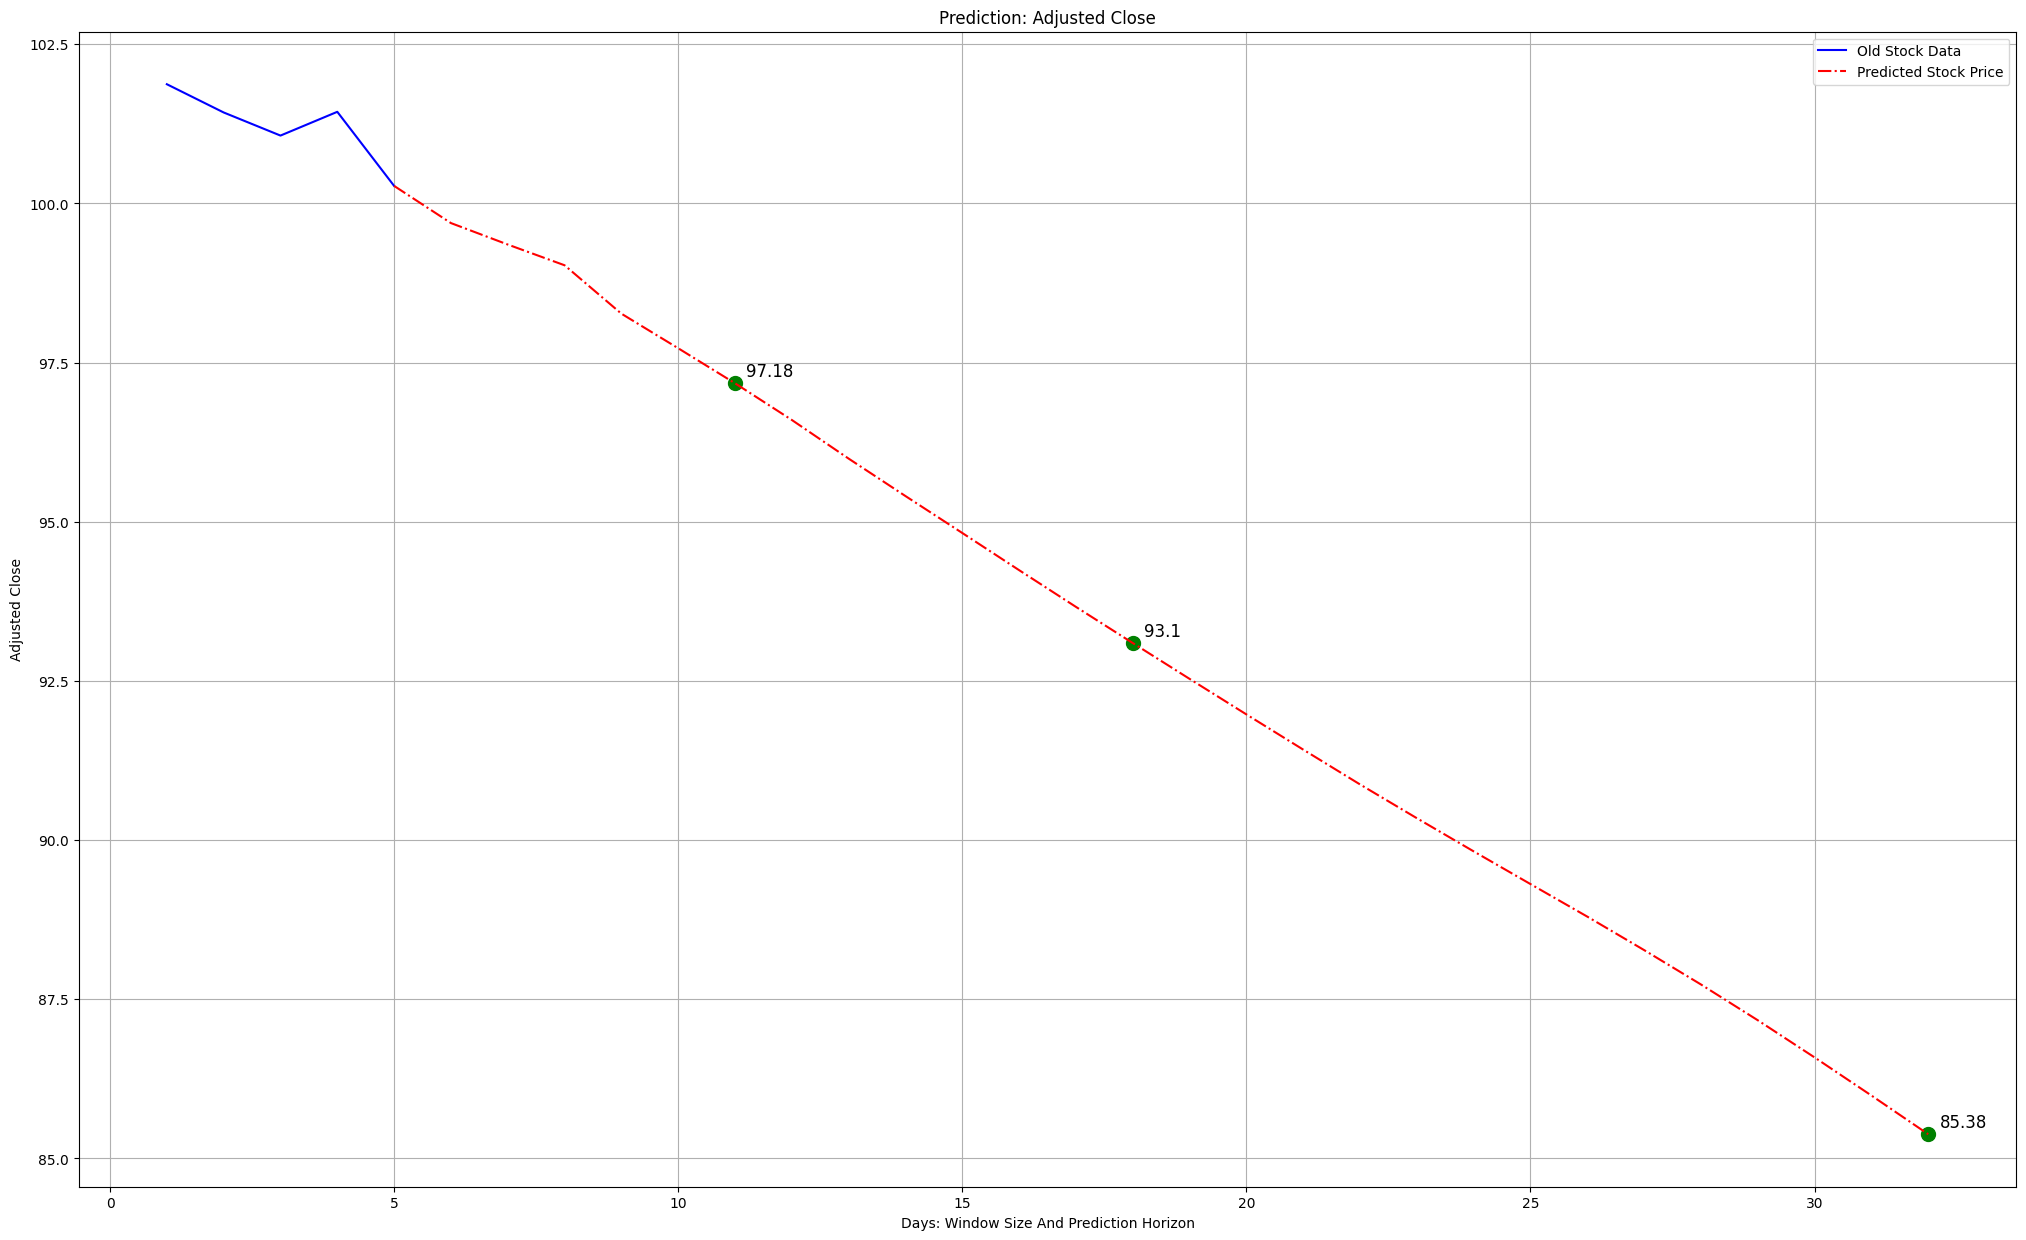


The predicted Adjusted Close for day 7 is: 97.18
The predicted Adjusted Close for day 14 is: 93.1
The predicted Adjusted Close for day 28 is: 97.18

Trading Recommendation after 28 days: Sell!
-----------------------------------------

######################
BTC-USD
######################


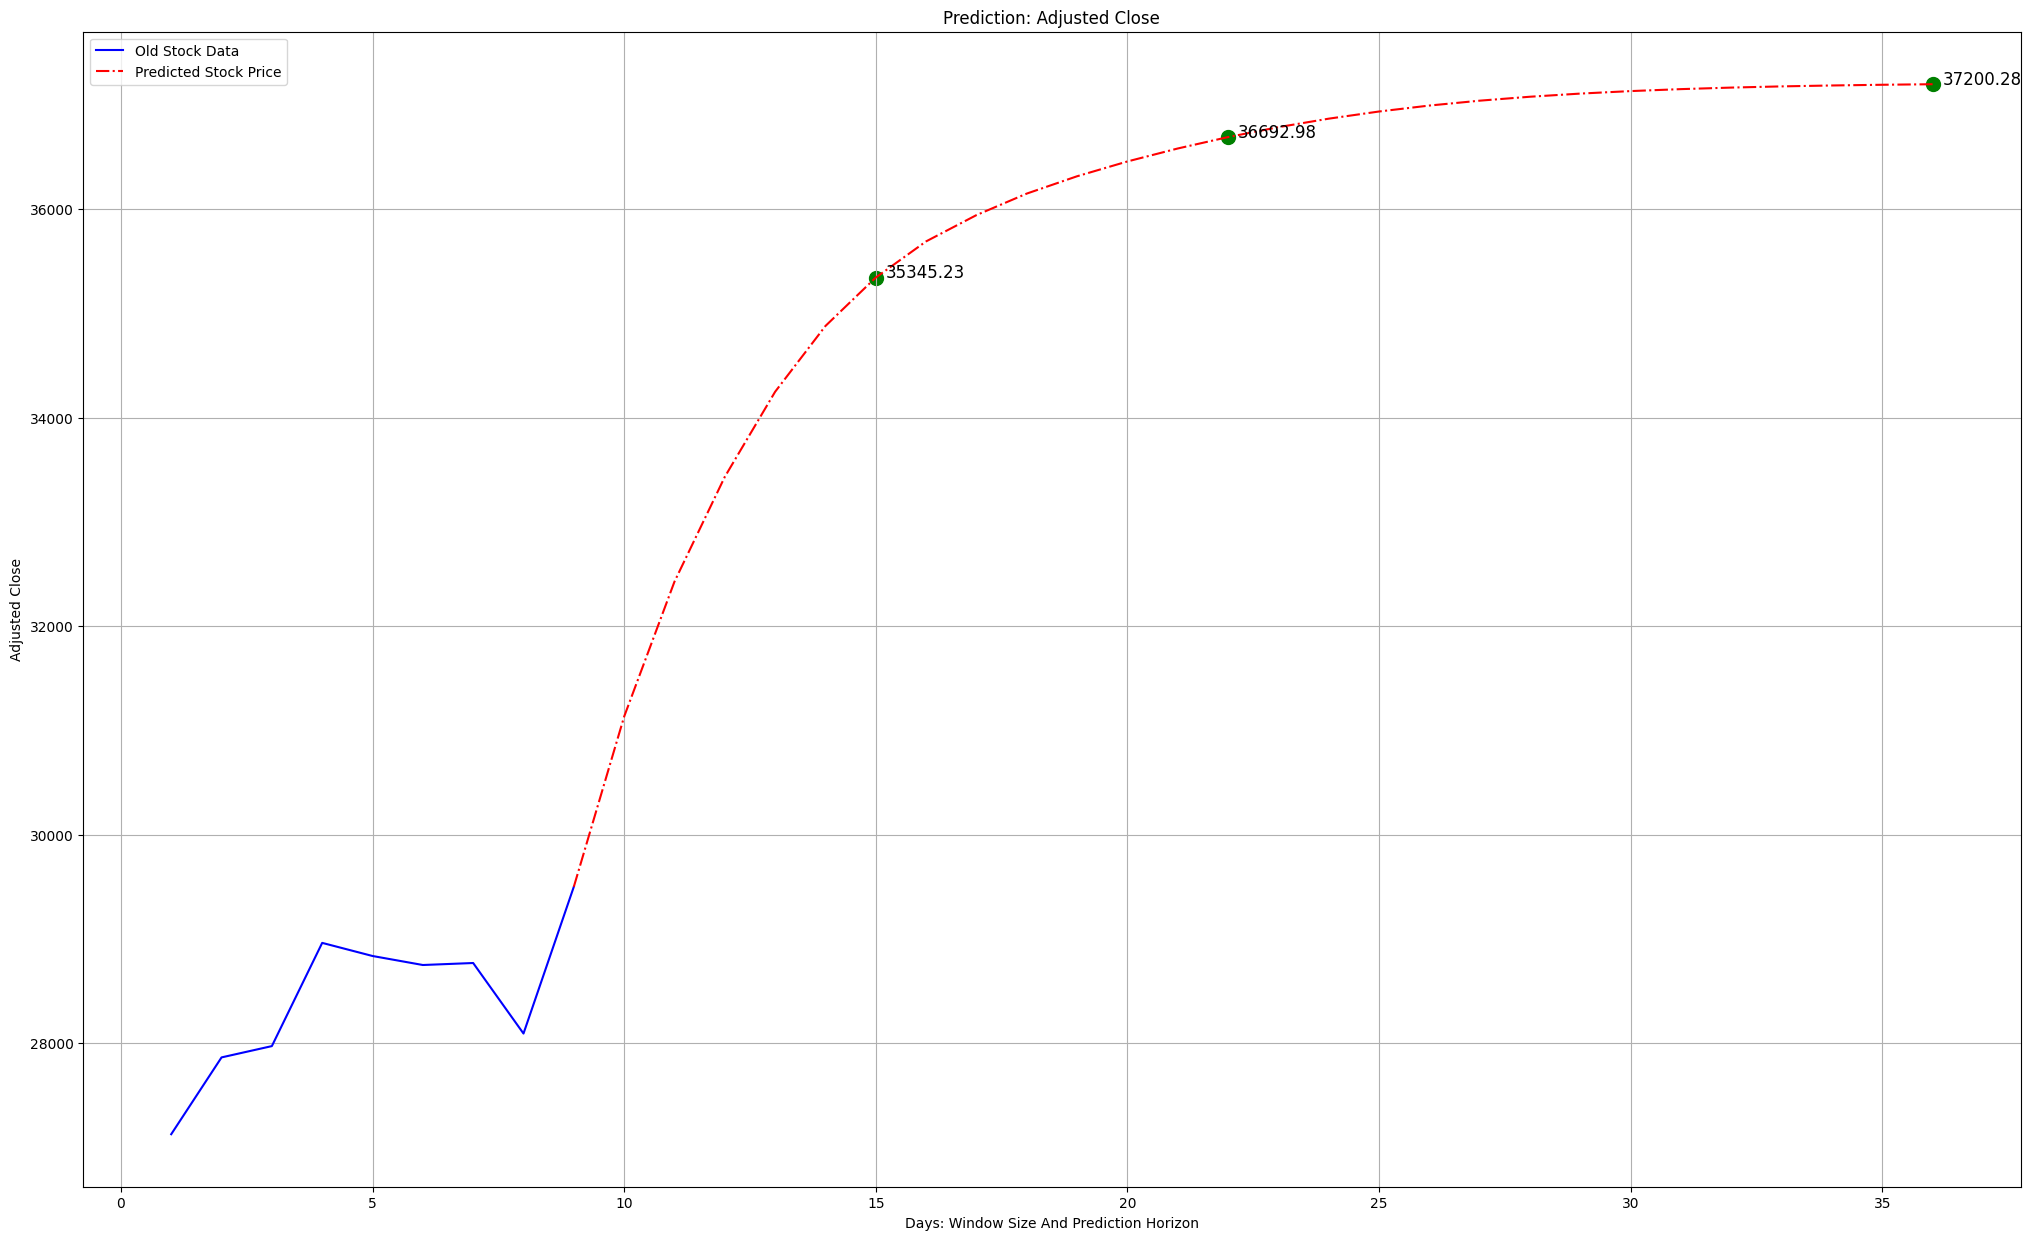


The predicted Adjusted Close for day 7 is: 35345.23
The predicted Adjusted Close for day 14 is: 36692.98
The predicted Adjusted Close for day 28 is: 35345.23

Trading Recommendation after 28 days: Hold!
-----------------------------------------

######################
ETSY
######################


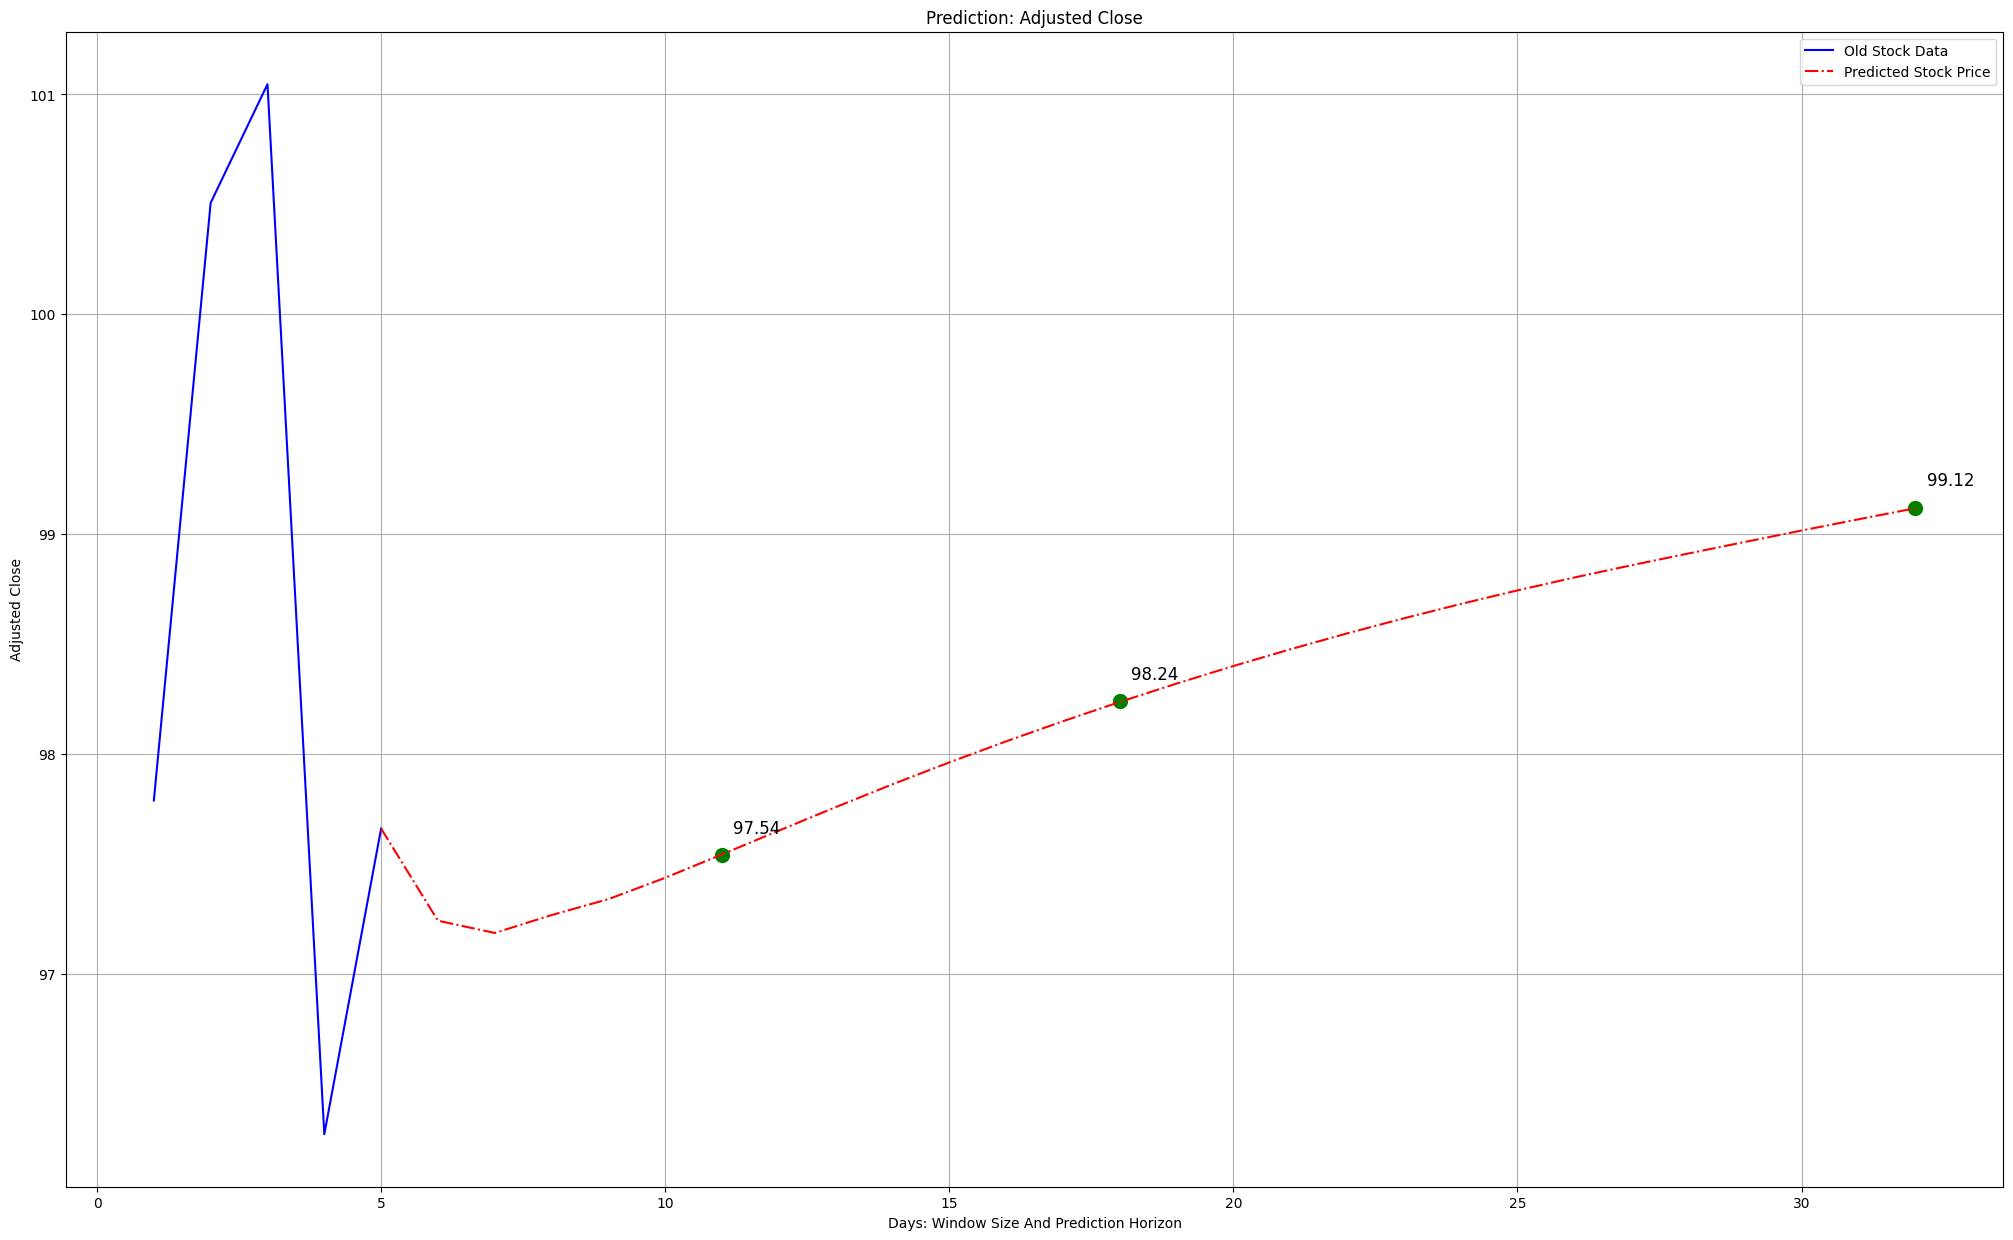


The predicted Adjusted Close for day 7 is: 97.54
The predicted Adjusted Close for day 14 is: 98.24
The predicted Adjusted Close for day 28 is: 97.54

Trading Recommendation after 28 days: Hold!
-----------------------------------------

######################
JNJ
######################


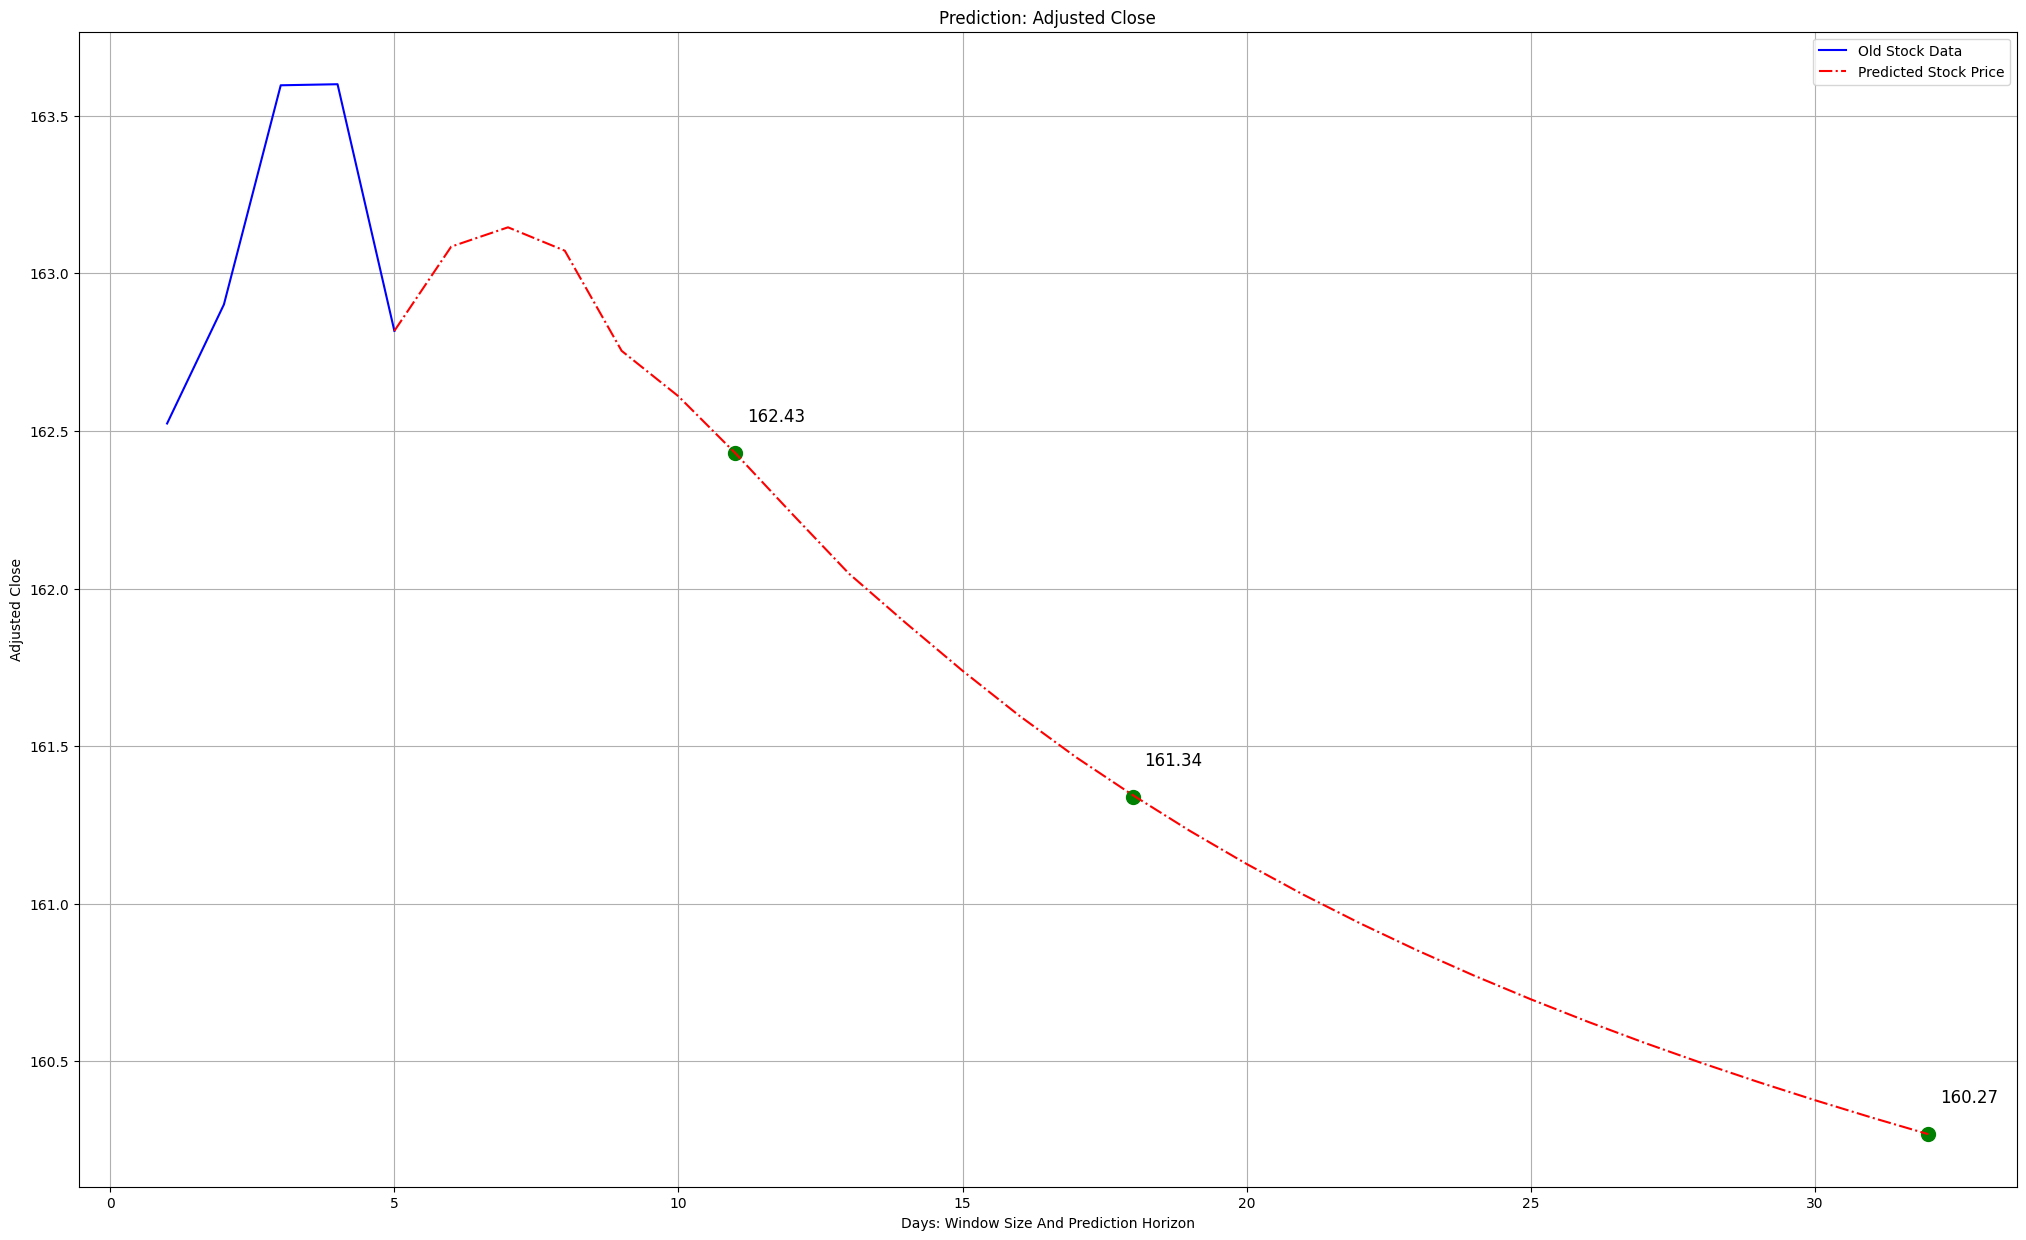


The predicted Adjusted Close for day 7 is: 162.43
The predicted Adjusted Close for day 14 is: 161.34
The predicted Adjusted Close for day 28 is: 162.43

Trading Recommendation after 28 days: Sell!
-----------------------------------------

######################
TSLA
######################


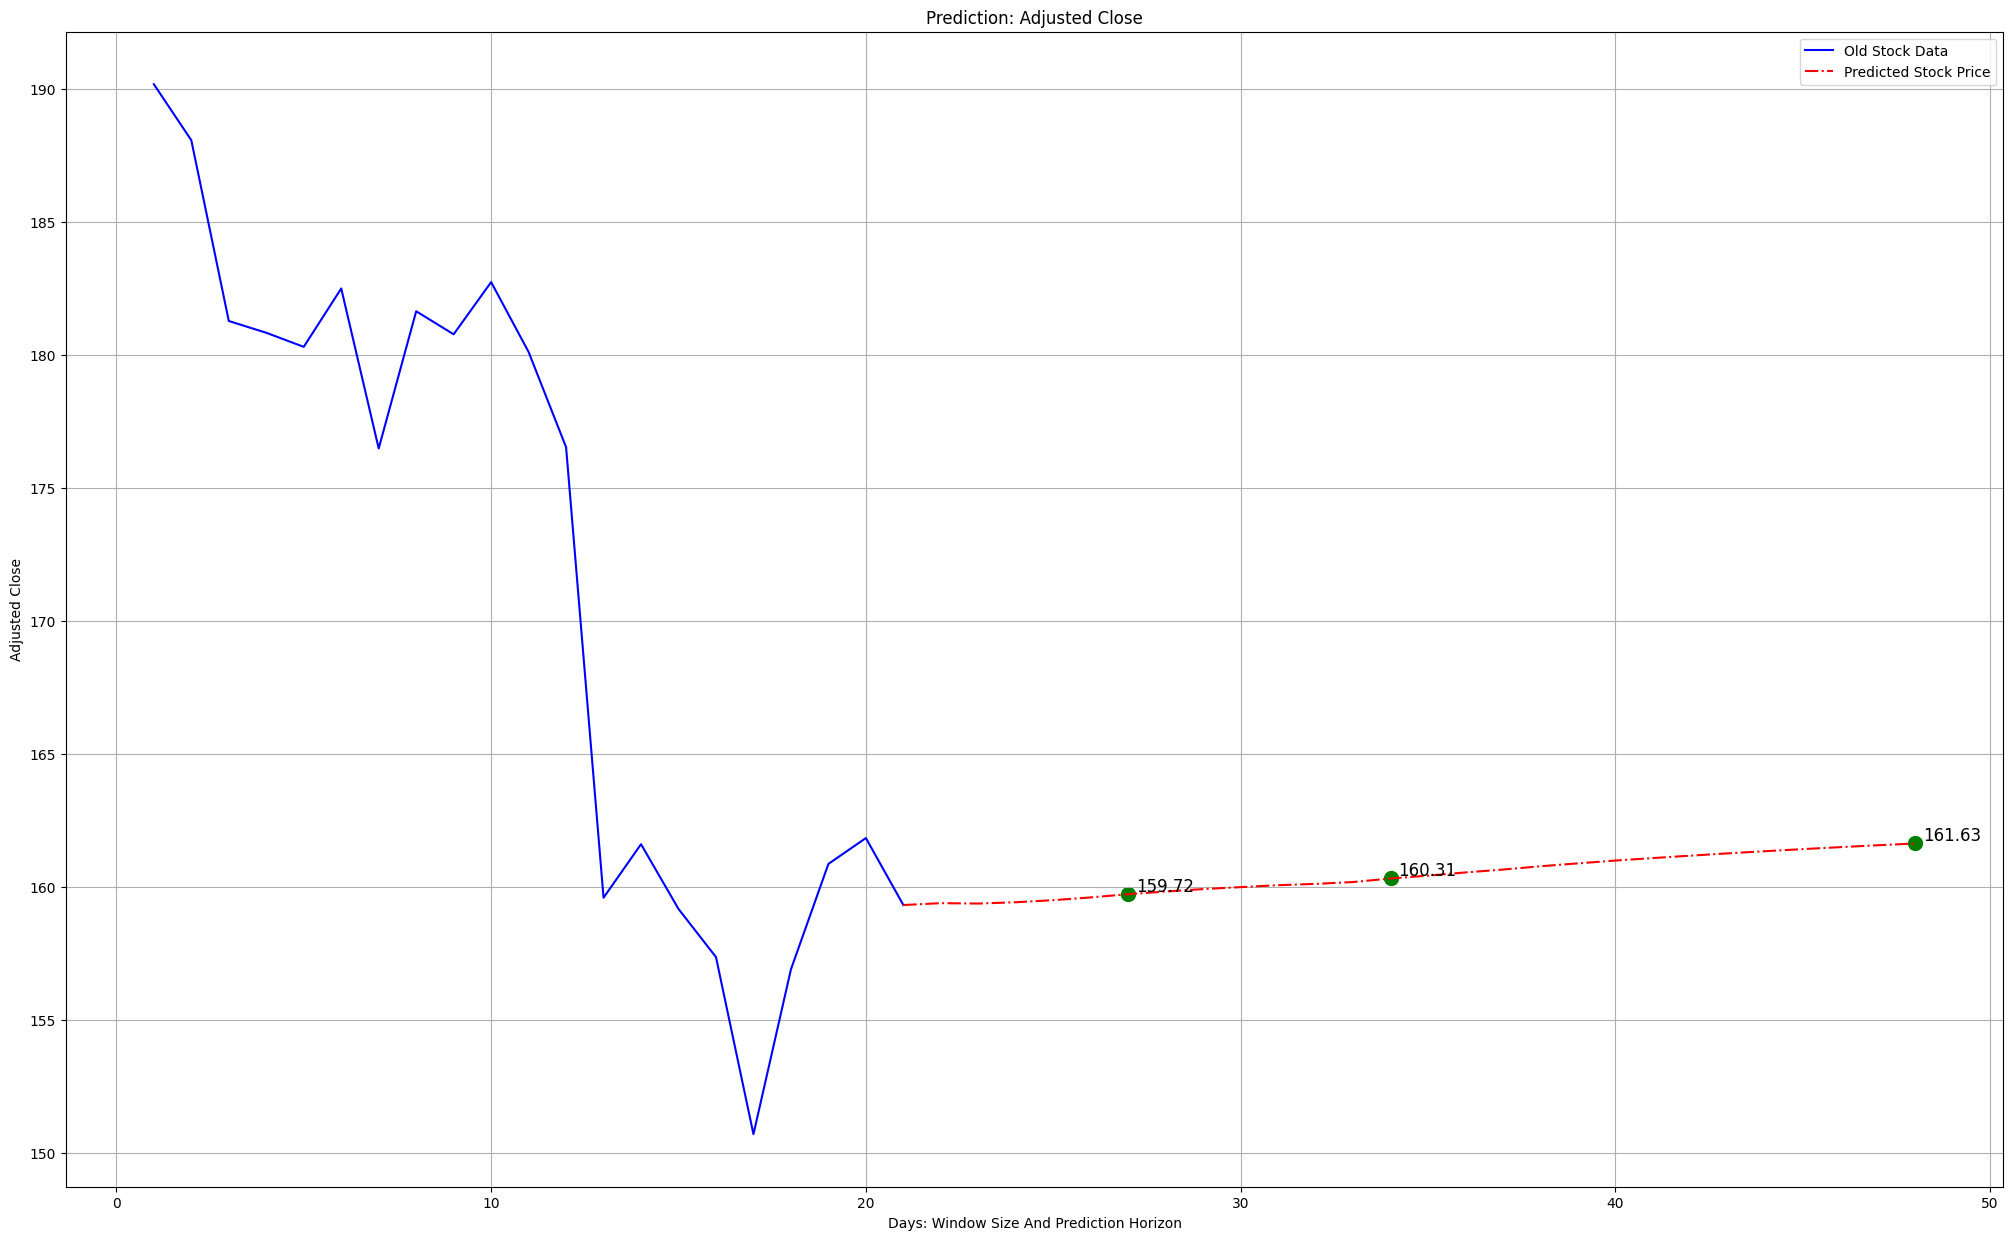


The predicted Adjusted Close for day 7 is: 159.72
The predicted Adjusted Close for day 14 is: 160.31
The predicted Adjusted Close for day 28 is: 159.72

Trading Recommendation after 28 days: Hold!
-----------------------------------------



In [51]:
# use the function for visualization
visualization_prediction(prediction)